- [3.1 Overview](#3_1)
- [3.2 Loading and Imports](#3_2)
- [3.3 Exploring Data](#3_3)
    - [3.3.1 Industry, Job Level, Location Background](#3_3_1)
        - [3.3.1.1 Firm and Industries](#3_3_1_1)
        - [3.3.1.2 Job Level](#3_3_1_2)
        - [3.3.1.3 Location](#3_3_1_3)
    - [3.3.2 Job Reviews](#3_3_2)
        - [3.3.2.1 Basic Texts Stats](#3_3_2_1)
        - [3.3.2.2 Common Keywords](#3_3_2_2)
        - [3.3.2.3 LDA](#3_3_2_3)
        - [3.3.2.4 Keyword Analysis](#3_3_2_4)
        - [3.3.2.5 Pro/Cons Correlation](#3_3_2_5)
        - [3.3.2.6 Industry and Level Specific Ratings](#3_3_2_6)
- [3.4 Summary](#3_4)
- [3.5 Export](#3_5)

### 3.1 Overview <a id = '3_1'></a>
For EDA, I questions I'd like to answer:
- What variable has the highest effect on satisfaction rate?
- What are the key words associated for satisfaction and dissastifaction rate?
- How does this vary for different industries? Positions?

### 3.2 Loading and Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy

In [41]:
df = pd.read_csv('/Users/Andre/OneDrive/Desktop/1_Glassdoor_Project/CleanedData/clean_data.csv')
df.head(5)

C:\Users\Andre\AppData\Local\Temp\ipykernel_28208\2760057219.py:1: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Andre/OneDrive/Desktop/1_Glassdoor_Project/CleanedData/clean_data.csv')


firm                   job_title            status years  \
0  ASDA               Night Stocker   Former Employee     1   
1  ASDA         Warehouse Operative  Current Employee   >10   
2  ASDA                Availibility  Current Employee     1   
3  ASDA  Customer Service Assistant  Current Employee     5   
4  ASDA            Checkout Support  Current Employee     1   

                      location  overall_rating  work_life_balance  \
0  Glasgow, Scotland, Scotland               3                3.0   
1     London, England, England               5                5.0   
2     London, England, England               3                3.0   
3  Glasgow, Scotland, Scotland               3                5.0   
4        Cardiff, Wales, Wales               5                4.0   

   culture_values  career_opp  comp_benefits  senior_mgmt  \
0             2.0         3.0            3.0          2.0   
1             5.0         5.0            5.0          5.0   
2             2.0         3.0            3.0          2.0   
3             4.0         3.0            2.0          4.0   
4             5.0         4.0            4.0          5.0   

                                            headline  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2             Good company, cares about employees...   
3  Good culture, Great group of people to work wi...   
4                                    Working in asda   

                                                pros  \
0  If you live nearby and are physically  sound t...   
1   the freshness,good,support,freedom and  attitude   
2           Helpful and friendly working environment   
3  Easy work, good training, 10% off discount car...   
4  I have felt like i was working among my family...   

                                                cons  \
0  Multi skills or greater performance are not fi...   
1    nothing nothing nothing nothing nothing nothing   
2  Salary is not attractive compare to the curren...   
3  Career progression slow, with many people sitt...   
4                      I can't really think of any .   

                                       combined_text  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2  Good company, cares about employees... Helpful...   
3  Good culture, Great group of people to work wi...   
4  Working in asda I have felt like i was working...   

                                      processed_text  
0  mixed depend Skills Manager seriously absent c...  
1  good freshness good support freedom   attitude...  
2  good company care employee helpful friendly wo...  
3  good culture great group people work career pr...  
4         work asda feel like work family work think

In [42]:
df.iloc[2, 3] = str(df.iloc[2, 3])
df.dtypes

firm                  object
job_title             object
status                object
years                 object
location              object
overall_rating         int64
work_life_balance    float64
culture_values       float64
career_opp           float64
comp_benefits        float64
senior_mgmt          float64
headline              object
pros                  object
cons                  object
combined_text         object
processed_text        object
dtype: object

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242755 entries, 0 to 242754
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   firm               242755 non-null  object 
 1   job_title          242702 non-null  object 
 2   status             140598 non-null  object 
 3   years              98024 non-null   object 
 4   location           242755 non-null  object 
 5   overall_rating     242755 non-null  int64  
 6   work_life_balance  242755 non-null  float64
 7   culture_values     242755 non-null  float64
 8   career_opp         242755 non-null  float64
 9   comp_benefits      242755 non-null  float64
 10  senior_mgmt        242755 non-null  float64
 11  headline           242755 non-null  object 
 12  pros               242755 non-null  object 
 13  cons               242755 non-null  object 
 14  combined_text      242755 non-null  object 
 15  processed_text     242755 non-null  object 
dtypes:

## 3.3 Exploring the Data <a id="3_3"></a>

### 3.3.1 Industry, Job, Location analysis <a id="3_3_1"></a>
- We have info of location, firm, and job titles of employees
- To what extent does these effect our employee satisfaction of these places?

#### 3.3.1.1 Firm Industries <a id="3_3_1_3"></a>
- A good place to start is to start by classifying every industry, so we can see industry trends later on

In [7]:
### Map to each industry, with help of GPT 
# Feature engineering
industry_mapping = {
    'IBM': 'Tech',
    'McDonald-s': 'Food',
    'Google': 'Tech',
    'Deloitte': 'Consulting',
    'SAP': 'Tech',
    'Apple': 'Tech',
    'Citi': 'Financial Services',
    'HSBC-Holdings': 'Financial Services',
    'KPMG': 'Consulting',
    'J-P-Morgan': 'Financial Services',
    'Microsoft': 'Tech',
    'PwC': 'Consulting',
    'Oracle': 'Tech',
    'EY': 'Consulting',
    'Barclays': 'Financial Services',
    'American-Express': 'Financial Services',
    'Salesforce': 'Tech',
    'Thomson-Reuters': 'Media',
    'Vodafone': 'Telecommunications',
    'Goldman-Sachs': 'Financial Services',
    'Morgan-Stanley': 'Financial Services',
    'Marriott-International': 'Hospitality',
    'Tesco': 'Retail',
    'Deutsche-Bank': 'Financial Services',
    'BNY-Mellon': 'Financial Services',
    'BT': 'Telecommunications',
    'Booking-com': 'Tech',
    'CBRE': 'Real Estate',
    'Hilton': 'Hospitality',
    'McKinsey-and-Company': 'Consulting',
    'Unilever': 'Consumer Goods',
    'LinkedIn': 'Tech',
    'GlaxoSmithKline': 'Pharmaceuticals',
    'Bloomberg-L-P': 'Media',
    'Bain-and-Company': 'Consulting',
    'BNP-Paribas': 'Financial Services',
    'Capita': 'Consulting',
    'J-Sainsbury': 'Retail',
    'NHS': 'Healthcare',
    'Aon': 'Consulting',
    'Pearson': 'Education',
    'Marks-and-Spencer': 'Retail',
    'Willis-Towers-Watson': 'Consulting',
    'Primark': 'Retail',
    'Hyatt': 'Hospitality',
    'University-of-Michigan': 'Education',
    'Pizza-Hut': 'Food',
    'ASDA': 'Retail',
    'Boots': 'Retail',
    'Waitrose': 'Retail'
}

In [8]:
df['industry'] = df['firm'].map(industry_mapping)

# Insert the industry column right before the reviews column
index = df.columns.get_loc('firm')
df.insert(index, 'industry', df.pop('industry'))
df.head(3)

industry  firm            job_title            status years  \
0   Retail  ASDA        Night Stocker   Former Employee     1   
1   Retail  ASDA  Warehouse Operative  Current Employee   >10   
2   Retail  ASDA         Availibility  Current Employee     1   

                      location  overall_rating  work_life_balance  \
0  Glasgow, Scotland, Scotland               3                3.0   
1     London, England, England               5                5.0   
2     London, England, England               3                3.0   

   culture_values  career_opp  comp_benefits  senior_mgmt  \
0             2.0         3.0            3.0          2.0   
1             5.0         5.0            5.0          5.0   
2             2.0         3.0            3.0          2.0   

                                            headline  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2             Good company, cares about employees...   

                                                pros  \
0  If you live nearby and are physically  sound t...   
1   the freshness,good,support,freedom and  attitude   
2           Helpful and friendly working environment   

                                                cons  \
0  Multi skills or greater performance are not fi...   
1    nothing nothing nothing nothing nothing nothing   
2  Salary is not attractive compare to the curren...   

                                       combined_text  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2  Good company, cares about employees... Helpful...   

                                      processed_text  
0  mixed depend Skills Manager seriously absent c...  
1  good freshness good support freedom   attitude...  
2  good company care employee helpful friendly wo...

In [9]:
# df.industry.value_counts()
df.groupby('industry')['firm'].value_counts()

industry            firm                  
Consulting          Deloitte                  21075
                    EY                        15460
                    PwC                       13427
                    KPMG                      10320
                    McKinsey-and-Company       2015
                    Bain-and-Company           1730
                    Capita                     1628
                    Aon                        1481
                    Willis-Towers-Watson       1404
Consumer Goods      Unilever                   1966
Education           Pearson                    1431
                    University-of-Michigan     1333
Financial Services  J-P-Morgan                10496
                    Citi                       7411
                    HSBC-Holdings              5818
                    Barclays                   4278
                    American-Express           4222
                    Goldman-Sachs              3623
                    M

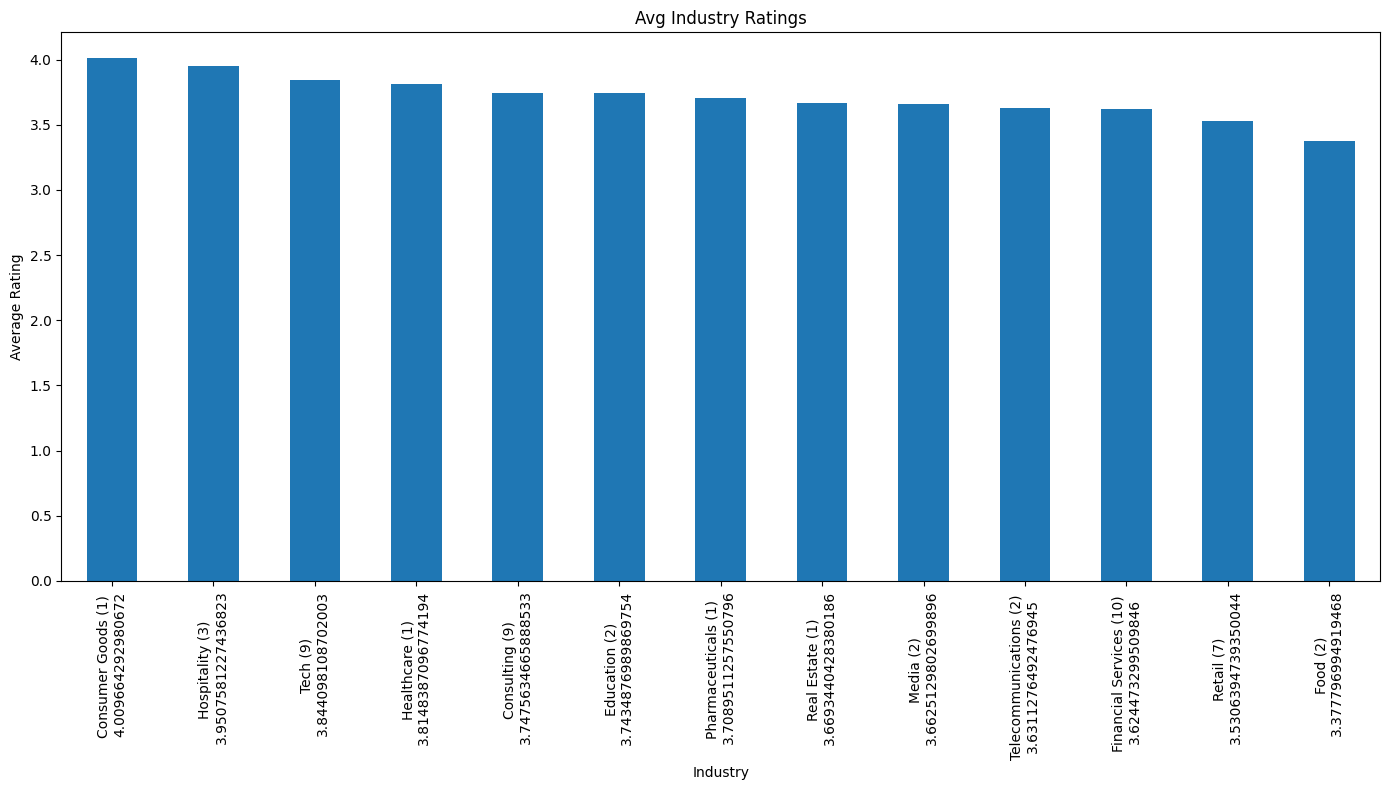

In [10]:
### a few industries that are only made up by one company, let's put that in our chart to avoid jumping to conclusions
### Top industry by ratings

industry_stats = df.groupby('industry').agg({
    'overall_rating': 'mean',
    'firm': 'nunique'
}).reset_index()

industry_stats.columns = ['industry', 'average_rating', 'num_firms']

# Add the number of firms to the industry name
industry_stats['industry_with_count'] = industry_stats.apply(
    lambda row: f"{row['industry']} ({row['num_firms']}) \n{row['average_rating']}", axis=1
)

industry_stats = industry_stats.sort_values(by='average_rating', ascending=False)

fig, axs = plt.subplots(figsize=(14, 8))

industry_stats.plot(kind='bar', x='industry_with_count', y='average_rating', ax=axs, legend=False)
axs.set_xlabel('Industry')
axs.set_ylabel('Average Rating')
axs.set_title('Avg Industry Ratings')

plt.tight_layout()
plt.show()

Things to note:
- We ignore all the companies with counts of (1), "mention in final report due to lack of representation"
- Tech, Hospitality, Consulting, Financial Services, Retail, and Food is worth looking at
1) Tech 
2) Hospitality
3) Consulting and Financial Services
4) Retail and Food (with 2 counts yet average is the lowest)

#### 3.3.1.2 Job titles <a id="3_3_1_2"></a>
- One thing to consider about positions is the seniority of the their jobs (example: Entry, Mid, Senior, etc)
- We will classify our job titles into categories as well (Entry:1, Mid:2, Senior:3)

In [11]:
df.job_title.value_counts().head(50)

job_title
Manager                            7003
Consultant                         6615
Senior Consultant                  6179
Software Engineer                  5606
Associate                          5278
Analyst                            4911
Senior Associate                   3981
Vice President                     3503
Senior Manager                     2927
Senior Software Engineer           2804
Assistant Manager                  2792
Director                           2705
Business Analyst                   2559
Project Manager                    2338
Crew Member                        1681
Software Developer                 1656
Audit Associate                    1501
Senior Analyst                     1398
Customer Assistant                 1371
Account Executive                  1367
Associate Consultant               1356
Applications Developer             1310
Financial Analyst                  1290
Account Manager                    1234
Assistant Vice President      

In [12]:
df.job_title.value_counts().tail(40)

job_title
Global Executive                                     1
Senior Hadoop Developer                              1
Assistant Vice President, Tax                        1
Principal Cloud Sales                                1
Deputy Head of Events                                1
Hybrid Cloud Manager                                 1
Game Tester                                          1
Retail and Corporate                                 1
Organisation                                         1
Client Contact                                       1
Secondary Control                                    1
Senior Information Security Manager                  1
Entry Level Consultant                               1
Vice President Controls Manager                      1
Marketing and Project Manager                        1
ETL Architect                                        1
Global Competency Lead                               1
Test Specialist Data                                 1


We'll categorize the most common keywords for our jobs and create a new classification for these positions.

In [13]:
keywords_senior = ['ceo', 'cto', 'cfo', 'coo', 'cso', 'cmo', 'chief', 'senior', 'president', 'executive', 'head', 'director', 'chief', 'officer', 'partner', 'vp', 'head']
keywords_mid = ['lead', 'manager', 'specialist', 'supervisor', 'administrator', 'coordinator', 'planner', 'advisor', 'deputy']
### Include most blue collar jobs here that don't have higher level management key words attached to them
keywords_entry = ['intern', 'entry', 'associate', 'cashier', 'assistant', 'crew', 'trainee', 'junior', 'representative', 'clerk',
                   'operator', 'stocker', 'grocery', 'checkout', 'colleague', 'apprenticeship', 'picker', 'driver', 'desk', 'member','student',
                   'server', 'chef', 'cook', 'kitchen', 'gardener', 'attendent', 'checkout','shop','butcher','plumber']

def categorize_job(title):
    title_lower = str(title).lower()
    
    if any(keyword in title_lower for keyword in keywords_senior):
        return 3  # Senior level
    elif any(keyword in title_lower for keyword in keywords_mid):
        return 2  # Mid level
    elif any(keyword in title_lower for keyword in keywords_entry):
        return 1  # Entry/Blue level
    else:
        return -1  # let's inspect all -1 values and adjust keys as necessary

In [14]:
df['level'] = df['job_title'].apply(categorize_job)

# Insert the 'level' column before the 'job_title' column
job_title_index = df.columns.get_loc('job_title')
df.insert(job_title_index, 'level', df.pop('level'))
df.head(5)

industry  firm  level                   job_title            status years  \
0   Retail  ASDA      1               Night Stocker   Former Employee     1   
1   Retail  ASDA     -1         Warehouse Operative  Current Employee   >10   
2   Retail  ASDA     -1                Availibility  Current Employee     1   
3   Retail  ASDA      1  Customer Service Assistant  Current Employee     5   
4   Retail  ASDA      1            Checkout Support  Current Employee     1   

                      location  overall_rating  work_life_balance  \
0  Glasgow, Scotland, Scotland               3                3.0   
1     London, England, England               5                5.0   
2     London, England, England               3                3.0   
3  Glasgow, Scotland, Scotland               3                5.0   
4        Cardiff, Wales, Wales               5                4.0   

   culture_values  career_opp  comp_benefits  senior_mgmt  \
0             2.0         3.0            3.0          2.0   
1             5.0         5.0            5.0          5.0   
2             2.0         3.0            3.0          2.0   
3             4.0         3.0            2.0          4.0   
4             5.0         4.0            4.0          5.0   

                                            headline  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2             Good company, cares about employees...   
3  Good culture, Great group of people to work wi...   
4                                    Working in asda   

                                                pros  \
0  If you live nearby and are physically  sound t...   
1   the freshness,good,support,freedom and  attitude   
2           Helpful and friendly working environment   
3  Easy work, good training, 10% off discount car...   
4  I have felt like i was working among my family...   

                                                cons  \
0  Multi skills or greater performance are not fi...   
1    nothing nothing nothing nothing nothing nothing   
2  Salary is not attractive compare to the curren...   
3  Career progression slow, with many people sitt...   
4                      I can't really think of any .   

                                       combined_text  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2  Good company, cares about employees... Helpful...   
3  Good culture, Great group of people to work wi...   
4  Working in asda I have felt like i was working...   

                                      processed_text  
0  mixed depend Skills Manager seriously absent c...  
1  good freshness good support freedom   attitude...  
2  good company care employee helpful friendly wo...  
3  good culture great group people work career pr...  
4         work asda feel like work family work think

In [15]:
# inspect all -1s and add any additional key values if necessary
df_check = df[df['level'] == -1]

# Count occurrences of each unique job title in the filtered DataFrame and display the top 10
job_title_counts = df_check['job_title'].value_counts().head(50)
job_title_counts

job_title
Consultant                                      6615
Software Engineer                               5606
Analyst                                         4911
Business Analyst                                2559
Software Developer                              1656
Applications Developer                          1310
Financial Analyst                               1290
Sales                                            795
Business Technology Analyst                      684
Data Analyst                                     612
Software Development Engineer                    578
Customer Service                                 554
Systems Engineer                                 542
Auditor                                          528
Operations Analyst                               452
Data Scientist                                   437
Technical Support Engineer                       436
Investment Banking Analyst                       426
Principal Consultant                

In [16]:
### Completed checks, replace -1 with default middle management (2)
df['level'] = df['level'].replace({-1:2})
df.head(5)

industry  firm  level                   job_title            status years  \
0   Retail  ASDA      1               Night Stocker   Former Employee     1   
1   Retail  ASDA      2         Warehouse Operative  Current Employee   >10   
2   Retail  ASDA      2                Availibility  Current Employee     1   
3   Retail  ASDA      1  Customer Service Assistant  Current Employee     5   
4   Retail  ASDA      1            Checkout Support  Current Employee     1   

                      location  overall_rating  work_life_balance  \
0  Glasgow, Scotland, Scotland               3                3.0   
1     London, England, England               5                5.0   
2     London, England, England               3                3.0   
3  Glasgow, Scotland, Scotland               3                5.0   
4        Cardiff, Wales, Wales               5                4.0   

   culture_values  career_opp  comp_benefits  senior_mgmt  \
0             2.0         3.0            3.0          2.0   
1             5.0         5.0            5.0          5.0   
2             2.0         3.0            3.0          2.0   
3             4.0         3.0            2.0          4.0   
4             5.0         4.0            4.0          5.0   

                                            headline  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2             Good company, cares about employees...   
3  Good culture, Great group of people to work wi...   
4                                    Working in asda   

                                                pros  \
0  If you live nearby and are physically  sound t...   
1   the freshness,good,support,freedom and  attitude   
2           Helpful and friendly working environment   
3  Easy work, good training, 10% off discount car...   
4  I have felt like i was working among my family...   

                                                cons  \
0  Multi skills or greater performance are not fi...   
1    nothing nothing nothing nothing nothing nothing   
2  Salary is not attractive compare to the curren...   
3  Career progression slow, with many people sitt...   
4                      I can't really think of any .   

                                       combined_text  \
0  Mixed, it very much depends upon the Skills of...   
1  very good the freshness,good,support,freedom a...   
2  Good company, cares about employees... Helpful...   
3  Good culture, Great group of people to work wi...   
4  Working in asda I have felt like i was working...   

                                      processed_text  
0  mixed depend Skills Manager seriously absent c...  
1  good freshness good support freedom   attitude...  
2  good company care employee helpful friendly wo...  
3  good culture great group people work career pr...  
4         work asda feel like work family work think

In [17]:
### Let's check our levels:
condition = (df['industry'] == 'Tech') & (df['level'] == 3)
filtered_df = df.loc[condition, ['industry', 'level', 'job_title']]
filtered_df

industry  level                        job_title
6852       Tech      3         Senior Software Engineer
6857       Tech      3                   Senior Advisor
6872       Tech      3      Senior Interaction Designer
6877       Tech      3                     IT Executive
6907       Tech      3         Senior Software Engineer
...         ...    ...                              ...
226569     Tech      3                Account Executive
226572     Tech      3    Senior Member Technical Staff
226573     Tech      3                Account Executive
226576     Tech      3  Senior User Experience Designer
226577     Tech      3                   Senior Analyst

[19428 rows x 3 columns]

In [18]:
# Let's check the average rating of each firm within their different job levels

df_level = df.groupby(['industry', 'level'])['overall_rating'].mean().unstack()
df_level['total_avg_rating'] = df_level.sum(axis=1)
df_level

level                      1         2         3  total_avg_rating
industry                                                          
Consulting          3.781815  3.740937  3.741114         11.263866
Consumer Goods      4.104575  3.968175  4.120301         12.193051
Education           4.126113  3.576463  3.732082         11.434657
Financial Services  3.683066  3.627377  3.595021         10.905464
Food                3.313438  3.476025  3.477477         10.266941
Healthcare          3.960784  3.816550  3.681507         11.458842
Hospitality         3.854839  3.912494  4.161858         11.929190
Media               3.679339  3.660531  3.660584         11.000454
Pharmaceuticals     3.624535  3.764373  3.635438         11.024346
Real Estate         3.718310  3.617071  3.744341         11.079722
Retail              3.573590  3.448294  3.691824         10.713708
Tech                3.828585  3.848557  3.837091         11.514233
Telecommunications  3.655462  3.624004  3.645188         10.924654

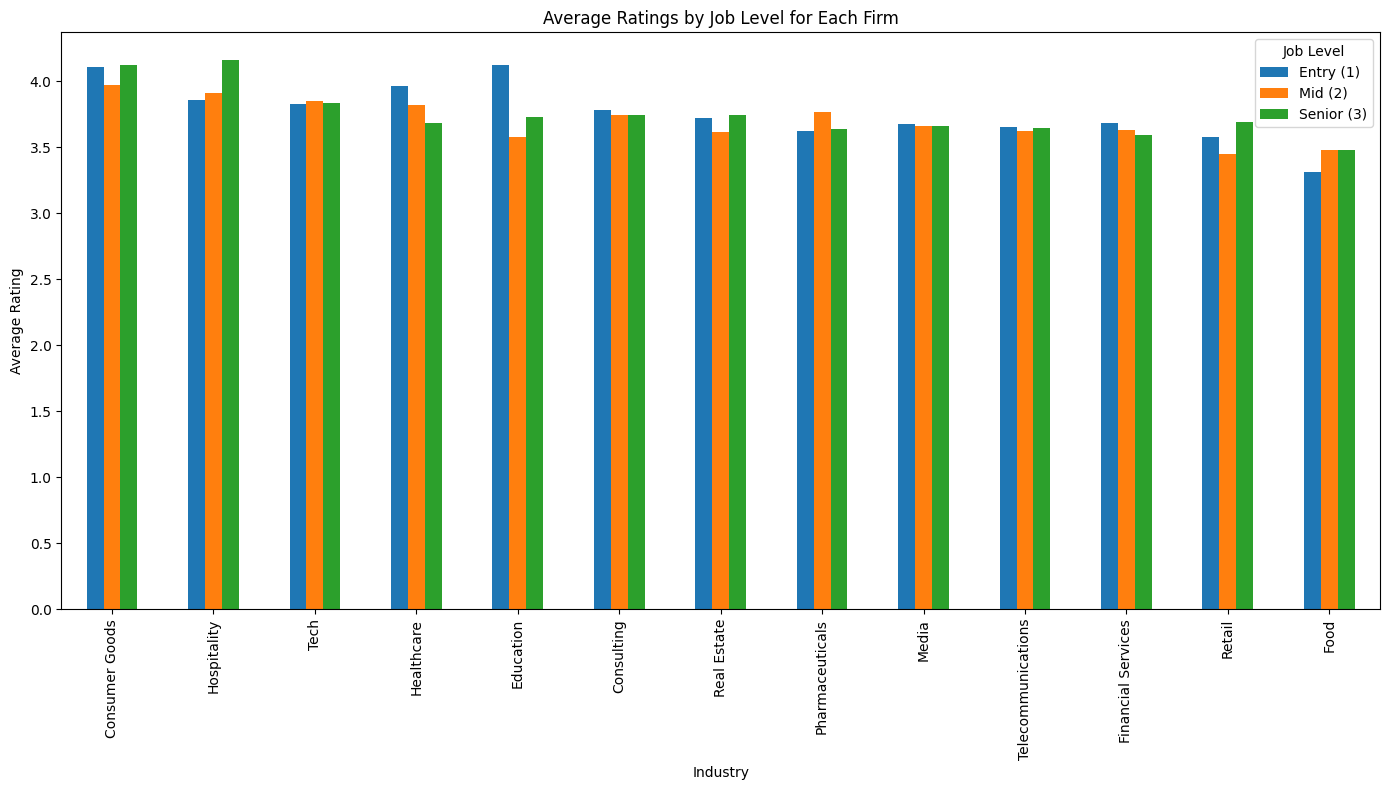

In [19]:
df_level = df_level.sort_values(by='total_avg_rating', ascending=False)
df_level = df_level.drop(columns=['total_avg_rating'])

fig, axs = plt.subplots(figsize=(14, 8))

df_level.plot(kind='bar', ax=axs)

axs.set_xlabel('Industry')
axs.set_ylabel('Average Rating')
axs.set_title('Average Ratings by Job Level for Each Firm')
axs.legend(title='Job Level', labels=['Entry (1)', 'Mid (2)', 'Senior (3)'])

plt.tight_layout()
plt.show()


### There may not be an interaction, outcome of result is effected 
### Does job level effect overall rating? Is it vary in industries, then yes.

Observations:
- My prediction was the higher seniority, the higher the satisfaction. This seems to not be the case in several industries! (Financial services, consulting, tech)
- Tech has higher in every job level than financial services and consulting (we have the most samples for these). 
    - Seniority within a company dosen't necessarily contribute to higher satisfaction, its seems to be all throughout
- Retail and Food has much lower level 1 ratings than level 3 ratings (This makes sense)

#### 3.3.1.3 Location<a id ='3_3_1_3'></a>
- Now let's check location ratings, the last time we check the 


In [20]:
df['location'].nunique()

275

In [21]:
#We still have 275 location, so let's pick the top 100 most reviewed locations and take a look at those
top100 = df['location'].value_counts().head(100).index
df_top100 = df[df['location'].isin(top100)]

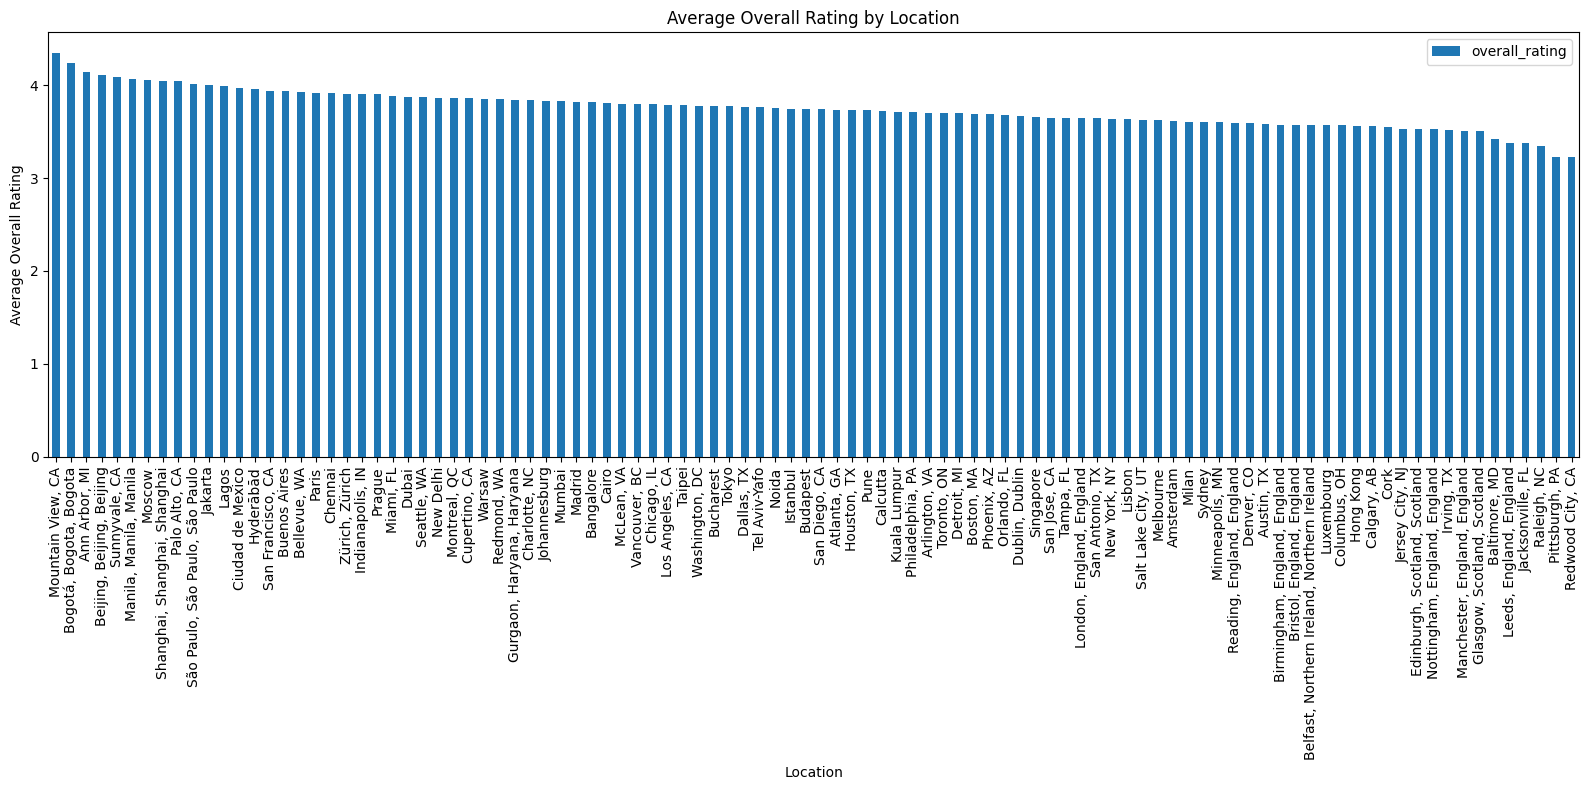

In [22]:
df_location = df_top100.groupby(by='location').agg({'overall_rating':'mean'}).reset_index()
df_location.sort_values(by='overall_rating', inplace= True, ascending=False)

fig, axs = plt.subplots(figsize = (16,8))

df_location.plot(kind='bar', x='location', y='overall_rating', ax = axs)
axs.set_xlabel('Location')
axs.set_ylabel('Average Overall Rating')
axs.set_title('Average Overall Rating by Location')

plt.tight_layout()
plt.show()

Seems to not be country oriented, what about some cities makes it better to work at than others? We'll take a deeper look later

### 3.3.2 User ratings <a id = '3_3_2'></a>

Let's take a look at the correlation of the 5 ratings to the overall rating

#### 3.3.2.1 Correlation Matrix and Analysis <a id="3_3_2_1"></a>

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242755 entries, 0 to 242754
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   industry           242755 non-null  object 
 1   firm               242755 non-null  object 
 2   level              242755 non-null  int64  
 3   job_title          242702 non-null  object 
 4   status             140598 non-null  object 
 5   years              98024 non-null   object 
 6   location           242755 non-null  object 
 7   overall_rating     242755 non-null  int64  
 8   work_life_balance  242755 non-null  float64
 9   culture_values     242755 non-null  float64
 10  career_opp         242755 non-null  float64
 11  comp_benefits      242755 non-null  float64
 12  senior_mgmt        242755 non-null  float64
 13  headline           242755 non-null  object 
 14  pros               242755 non-null  object 
 15  cons               242755 non-null  object 
 16  co

In [24]:
### We want to see the correlation among all of these values
rate_cols = ['overall_rating', 'work_life_balance', 'culture_values', 'career_opp','comp_benefits', 'senior_mgmt','status','years','level']

#Let's also encode the categories now so we can check the correlation:
# '>10' becomes '10'
df['years'] = df['years'].replace('>10', '10')

# 'status' so that 'Former Employee' is 0 and 'Current Employee' is 1
df['status'] = df['status'].apply(str)
df['status'] = df['status'].str.strip()
df['status'] = df['status'].replace({'Former Employee': 0, 'Current Employee': 1})

df_rate = df[rate_cols] ###Temporarily drop null values, let's see if they are correlated at all
df_rate = df_rate.dropna(axis=0)

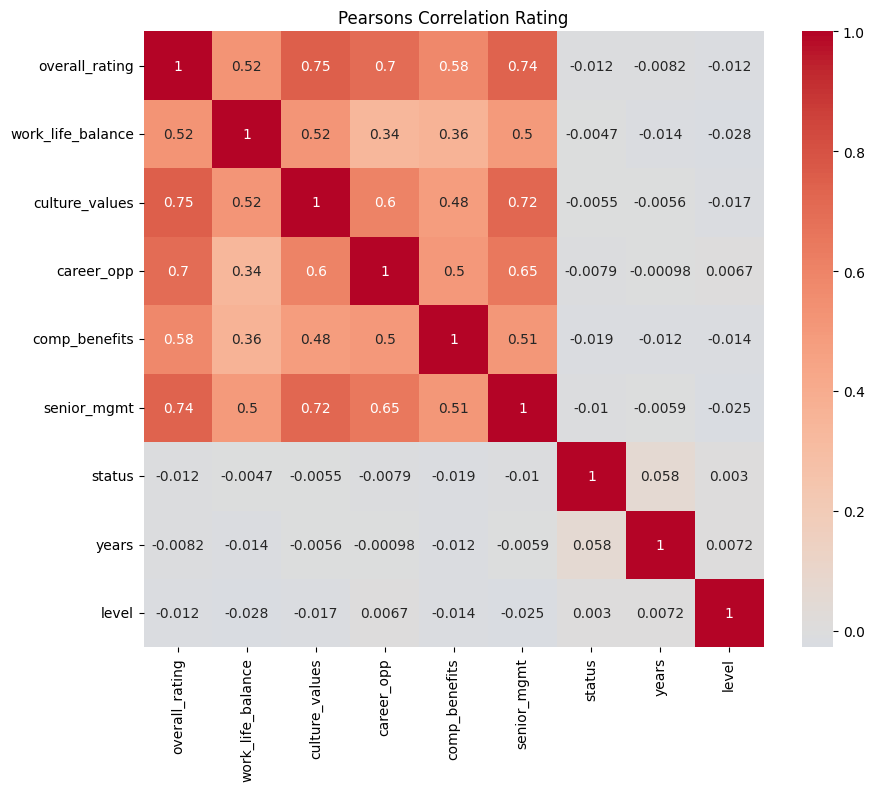

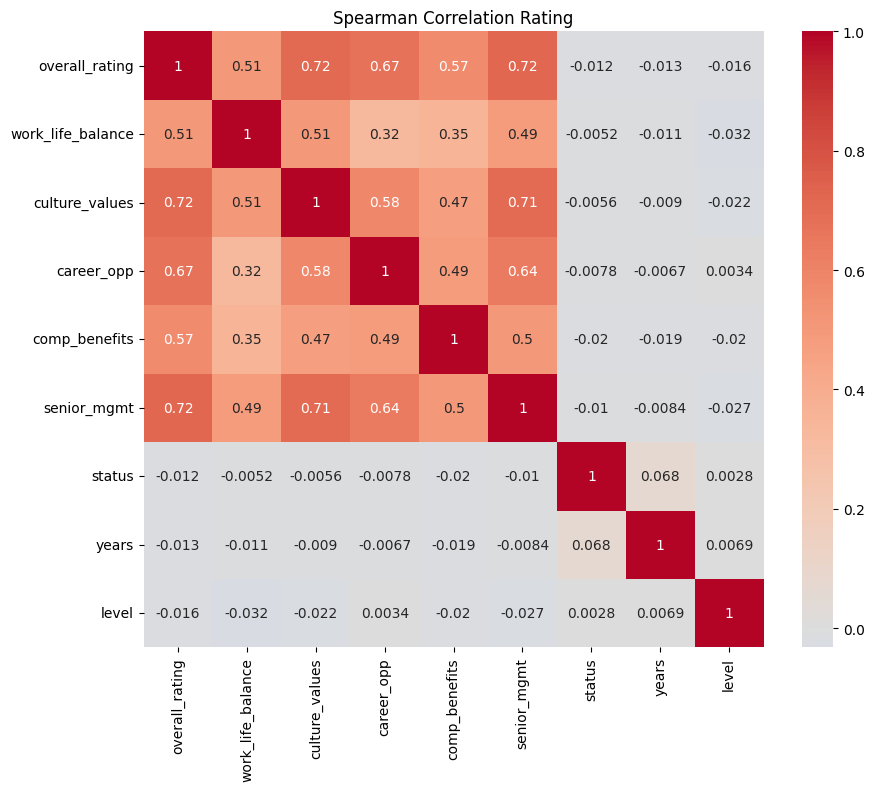

In [25]:
### Pearsons Correlation is ideal for continous variables, Spearman is ideal for Ordinal variables and monotonic relationships since it assumes equal intervals
### We will check both of these methodologies

correlation_matrix_pearson = df_rate.corr(method='pearson') # Pearson
correlation_matrix_spearman = df_rate.corr(method='spearman') # Spearman

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_pearson, annot=True, cmap='coolwarm', center=0)
plt.title('Pearsons Correlation Rating')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', center=0)
plt.title('Spearman Correlation Rating')
plt.show()

# tree based model, permutation 
# shaft, importance of each variabe
# linear, coefficients and p-values

This is interesting, the correlation for current/former, years they've worked, and level of employment is not significant
- I thought that the level of management one is in the industry leads to perhaps higher satisfaction
- The other metrics 5 seems to have much higher correlation, especially culture and senior management.

These factors have the most correlation
1) Culture values
2) Senior Management
3) Career Opportunities

Followed by:
4) Comp_benefits and Work life balance

#### 3.3.2.2 Testing <a id="3_3_2_2"></a>
- We will conduct statistical test to further test our variables relationship
- Will be conducted in a seperate notebook in `ExperimentDesign`

### 3.3.3 Employee Reviews Analysis
We investigate our reviews to see any common trends and keywords employees look for when considering job satisfaction

#### 3.3.3.1 Basic Text Stat <a id = "3_3_3_1"></a>
- Let's look at common word stats first, like word and char count in relation to ratings

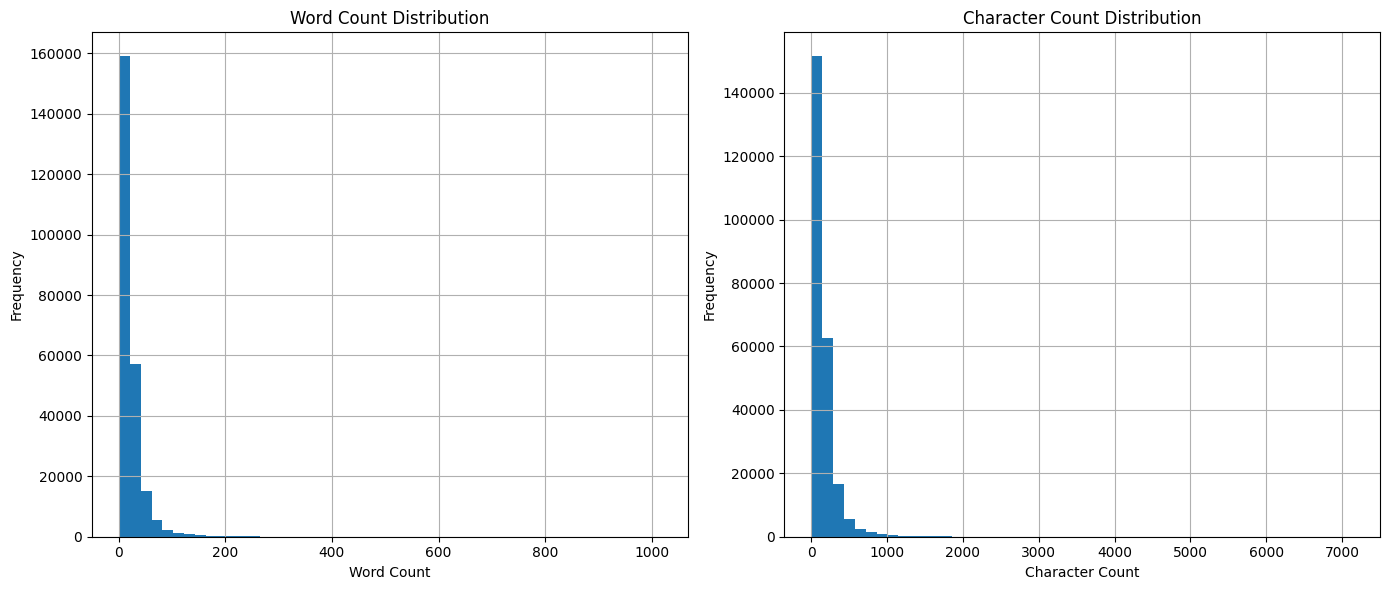

In [26]:
df['word_count'] = df['processed_text'].apply(lambda x: len(x.split()))
df['char_count'] = df['processed_text'].apply(lambda x: len(x))

# Plot histograms
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
df['word_count'].hist(bins=50)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df['char_count'].hist(bins=50)
plt.title('Character Count Distribution')
plt.xlabel('Character Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<Axes: xlabel='char_count', ylabel='overall_rating'>

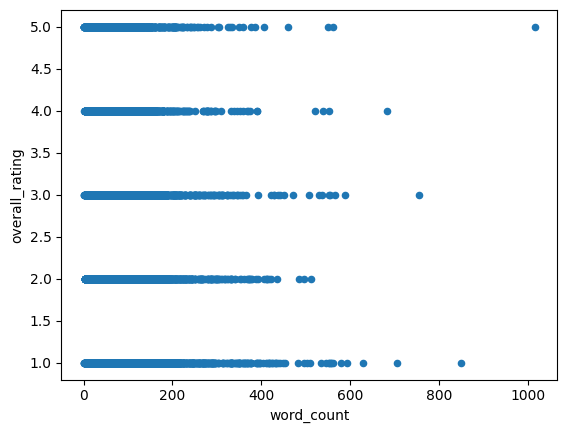

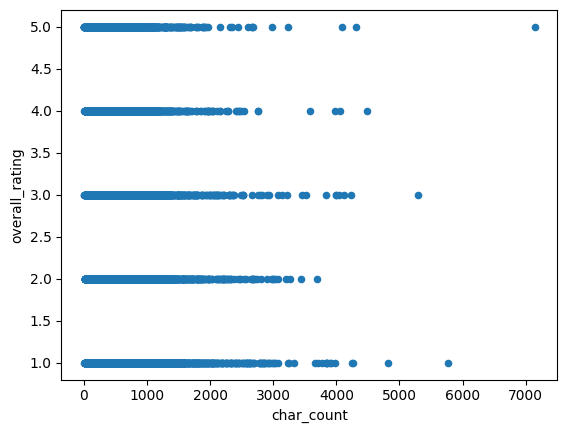

In [27]:
# Does the length of the review cause higher/lower ratings?
df.plot(kind='scatter', x='word_count',y ='overall_rating')
df.plot(kind='scatter', x='char_count',y ='overall_rating')

Seems rather consistent all across with a few outliers, dosen't seem like there is a correlation

#### 3.3.3.2 Common Words and Phrases <a id = "3_3_3_2"></a>

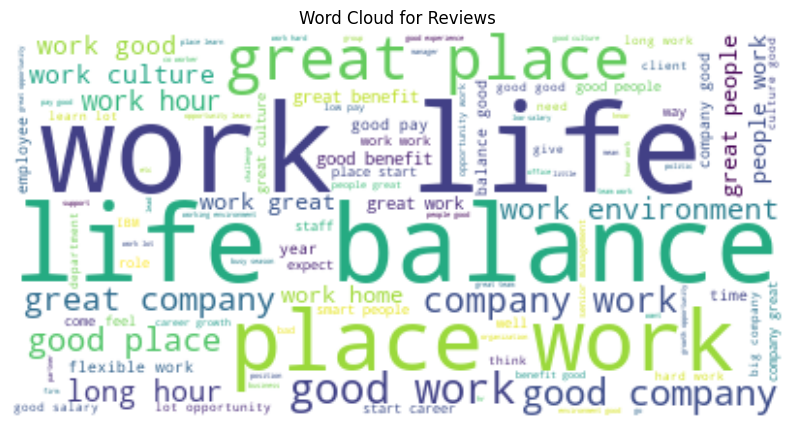

In [28]:
wordcloud = WordCloud(background_color='white', max_words=100).generate(' '.join(df['processed_text']))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Reviews')
plt.axis('off')
plt.show()

- We see all the buzzwords associated with work life, culture, life balance, but this dosen't show us much yet
- Let's use n-grams to see if we can find more usefull 'phrases' commonly used

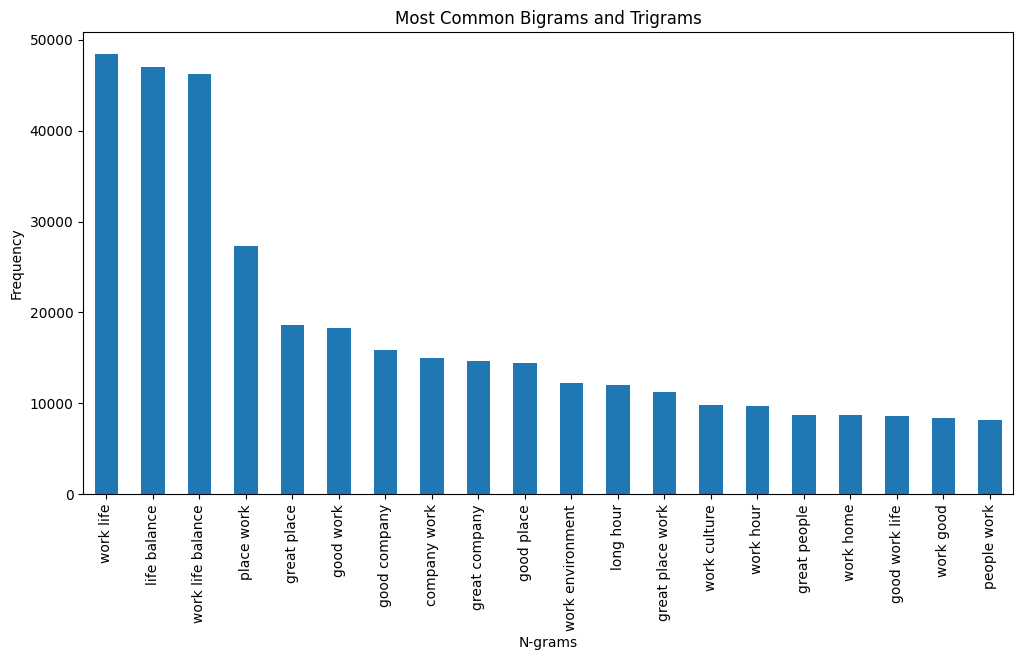

In [29]:
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=20)
X_ngrams = vectorizer.fit_transform(df['processed_text'])

ngrams_df = pd.DataFrame(X_ngrams.toarray(), columns=vectorizer.get_feature_names_out())  #easier to handle with as pandas df

# Plot most common n-grams
ngrams_df.sum().sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Most Common Bigrams and Trigrams')
plt.xlabel('N-grams')
plt.ylabel('Frequency')
plt.show()

'work life' and 'life balance' seems to pop up repeatedly even in the reviews

#### 3.3.3.3 Topic Modeling (LDA) <a id = "3_3_3_3"></a>
- Latent Dirichlet Allocation (LDA)
- Unsupervised classification of documents

In [30]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
tf = tf_vectorizer.fit_transform(df['processed_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42, n_jobs=-1)   #n_jobs = -1 uses all cores
lda.fit(tf)

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

display_topics(lda, tf_vectorizer.get_feature_names_out(), 10)

Topic 0:
employee work company benefit pay management year good great job
Topic 1:
work good great life balance company place culture opportunity environment
Topic 2:
work hour good long people time pay great job lot
Topic 3:
work good opportunity management project client firm culture senior team
Topic 4:
company people great work lot team change good product manager


All of these topics are relevant to the other ratings reviewers had to rate
- Common topics including good life balance, opportunities, culture, benefits, good hour, management, etc

#### 3.3.3.4 Keyword Analysis: High/Low ratings and Pro/Cons
- We also want to see if there are particular keywords in reference to higher and lower ratings of their jobs
- We start by analying pro and con columns, and perform sentiment analysis to see what is associated with higher/lower sentiments

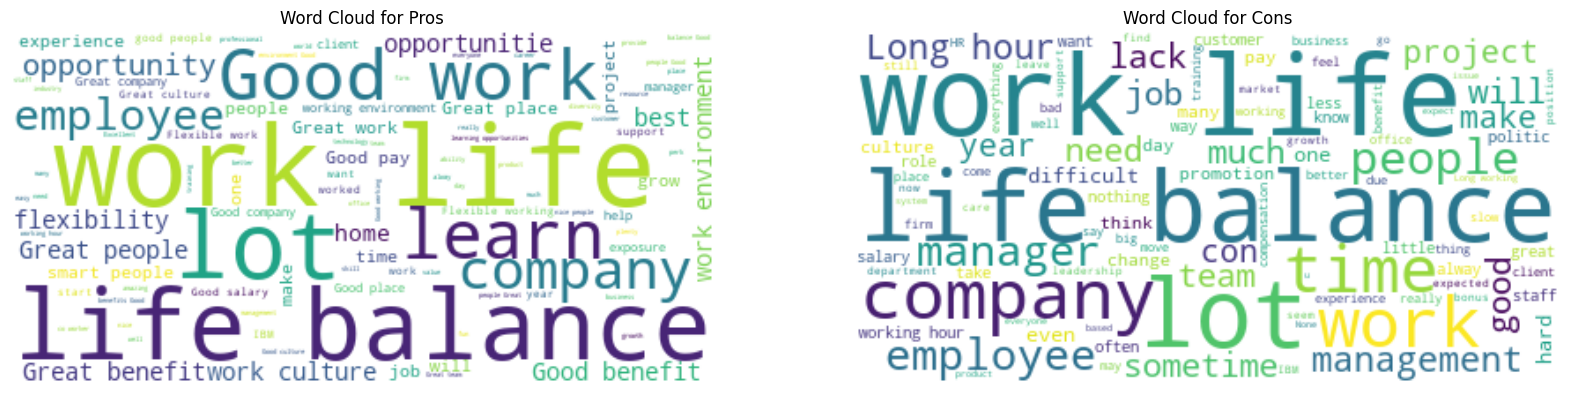

In [31]:
# word clouds for pros and cons
pros_text = ' '.join(df['pros'].fillna('').tolist())
cons_text = ' '.join(df['cons'].fillna('').tolist())

wordcloud_pros = WordCloud(background_color='white', max_words=100).generate(pros_text)
wordcloud_cons = WordCloud(background_color='white', max_words=100).generate(cons_text)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pros, interpolation='bilinear')
plt.title('Word Cloud for Pros')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_cons, interpolation='bilinear')
plt.title('Word Cloud for Cons')
plt.axis('off')

plt.show()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


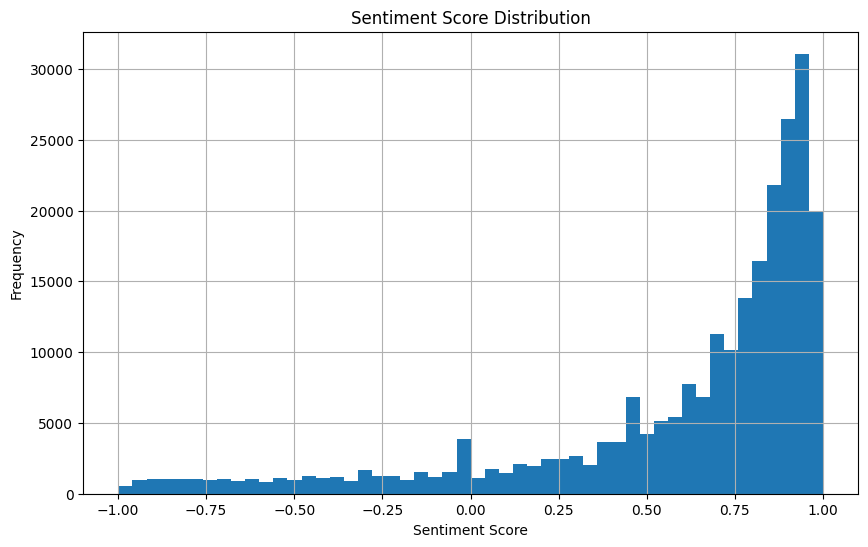

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

df['sentiment_score'] = df['combined_text'].apply(get_sentiment_score)

plt.figure(figsize=(10, 6))
df['sentiment_score'].hist(bins=50)
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [33]:
### Let's check if the sentiment score captures the overall_rating accurately
correlation = df['overall_rating'].corr(df['sentiment_score'])
print(correlation)

# won't be able to tell that based off the correlation
# strong correlation is .5, this is a weak-medium correlation. The words in text don't strong correlate with employee rating itself

0.43242988260506754


It seems like there is a moderate correlation with the sentiment analysis and the overall_rating, We will use our sentiment analysis as gauge of bad/good rating

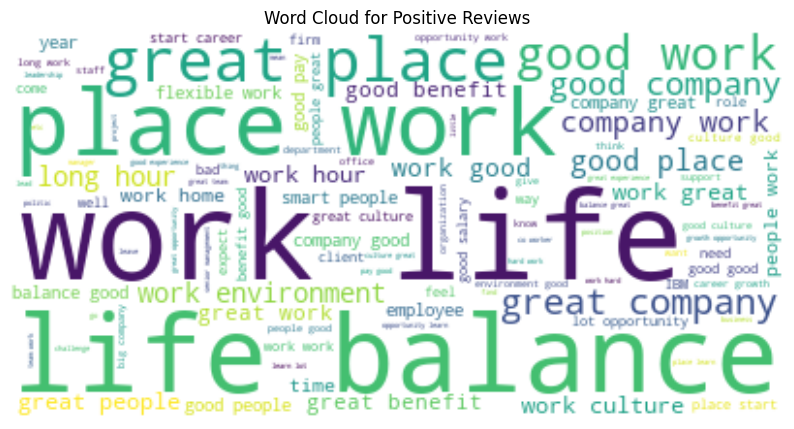

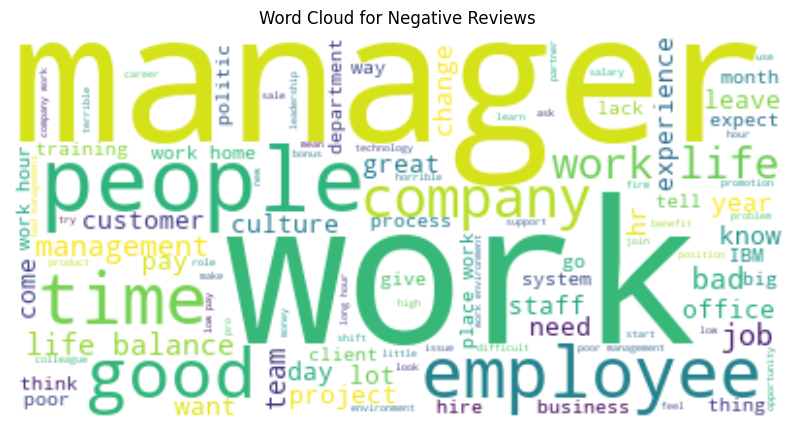

In [34]:
positive_reviews = df[df['sentiment_score'] > 0.5]['processed_text']
negative_reviews = df[df['sentiment_score'] < -0.5]['processed_text']

# word cloud for positive reviews
wordcloud_positive = WordCloud(background_color='white', max_words=100).generate(' '.join(positive_reviews))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis('off')
plt.show()

# word cloud for negative reviews
wordcloud_negative = WordCloud(background_color='white', max_words=100).generate(' '.join(negative_reviews))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis('off')
plt.show()

- positives seem to be good all throughout
- That's a massive bold `manager` for negatives, companies really need to do a better job with their managers.

#### 3.3.3.5 Correlation: Words and Overall Ratings

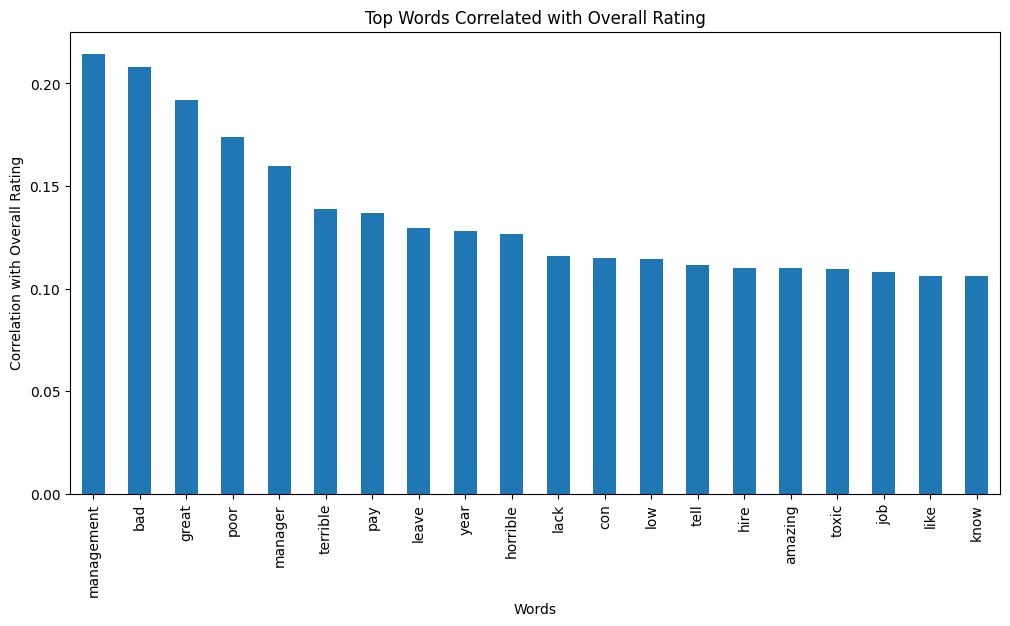

In [35]:
# Compute correlation between word counts and overall ratings
word_vectorizer = CountVectorizer(max_features=1000)
X_words = word_vectorizer.fit_transform(df['processed_text'])
word_features = pd.DataFrame(X_words.toarray(), columns=word_vectorizer.get_feature_names_out())
correlation = word_features.corrwith(df['overall_rating'])

# Plot the top correlated words
top_correlated_words = correlation.abs().sort_values(ascending=False).head(20)      #make sure we take absolute value
top_correlated_words.plot(kind='bar', figsize=(12, 6))
plt.title('Top Words Correlated with Overall Rating')
plt.xlabel('Words')
plt.ylabel('Correlation with Overall Rating')
plt.show()

- Of course good/bad connotation terms like bad, great, amazing, poor, horrible has the highest effect
- And we see again management, manager, and pay has the highest correlation to overall rating. Let's keep this in mind

#### 3.3.3.6 Industry and Level Specific Ratings <a id = '3_3_3_6'></a>
- So far we've done an analysis on everything in general, but different industries and levels of works should also have thier own conceerns.
- Let's test this by doing the same thing through all industries and levels

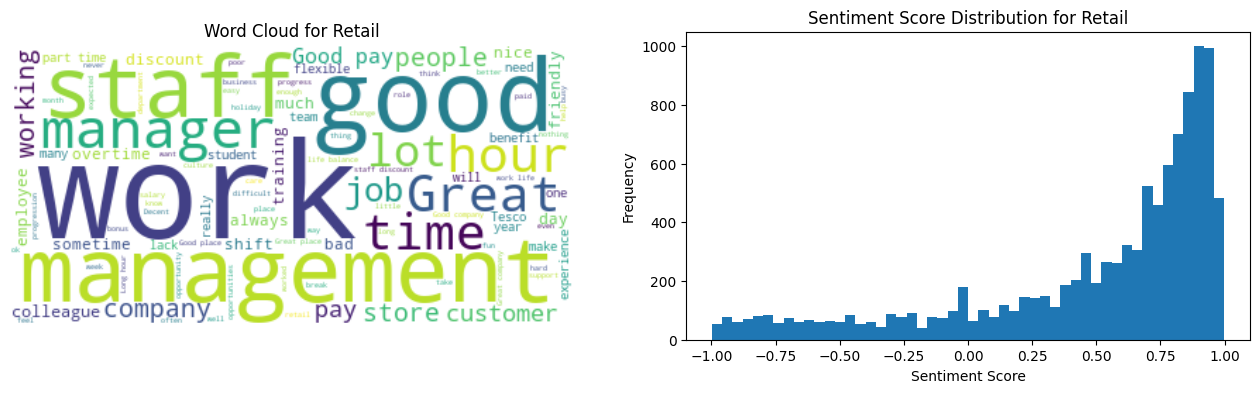

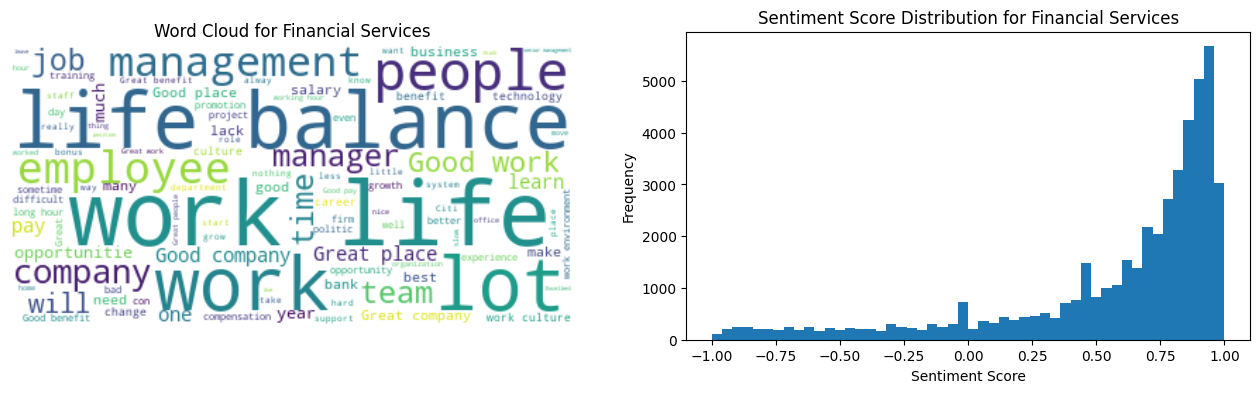

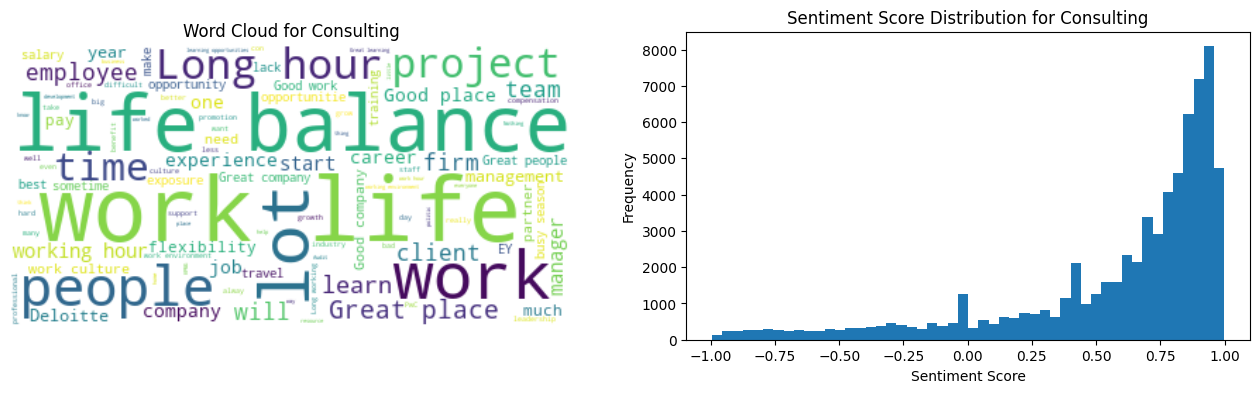

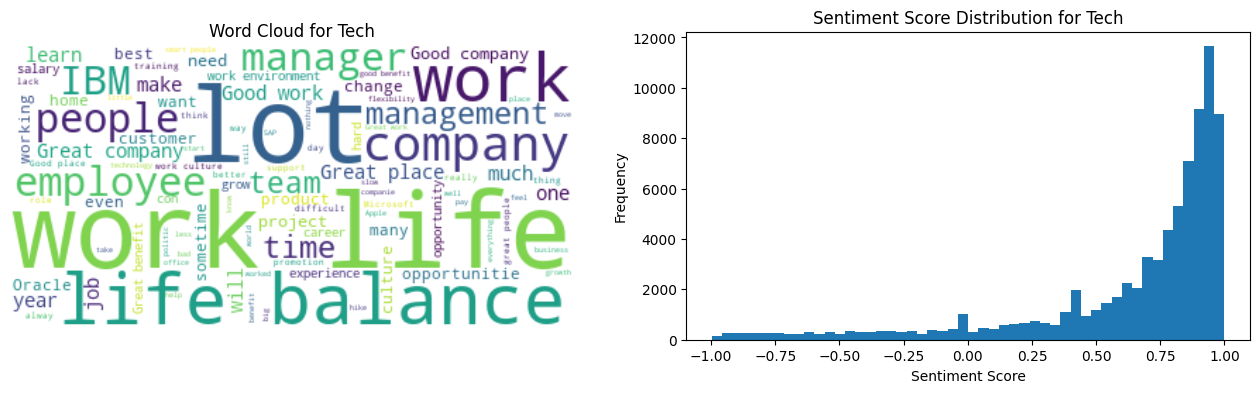

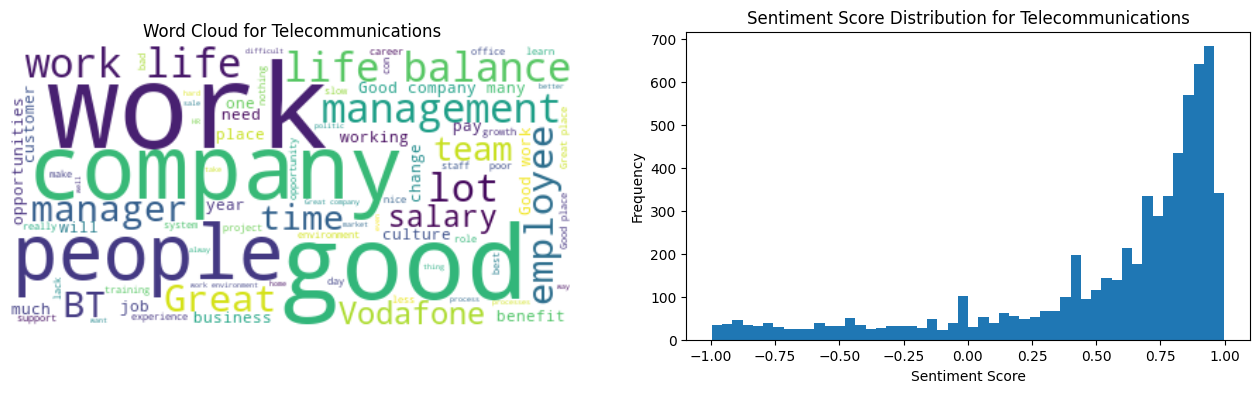

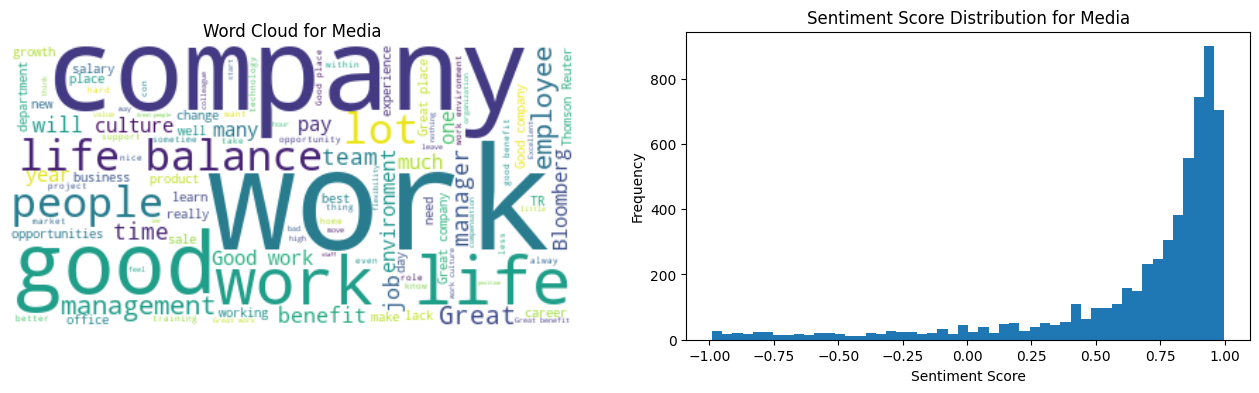

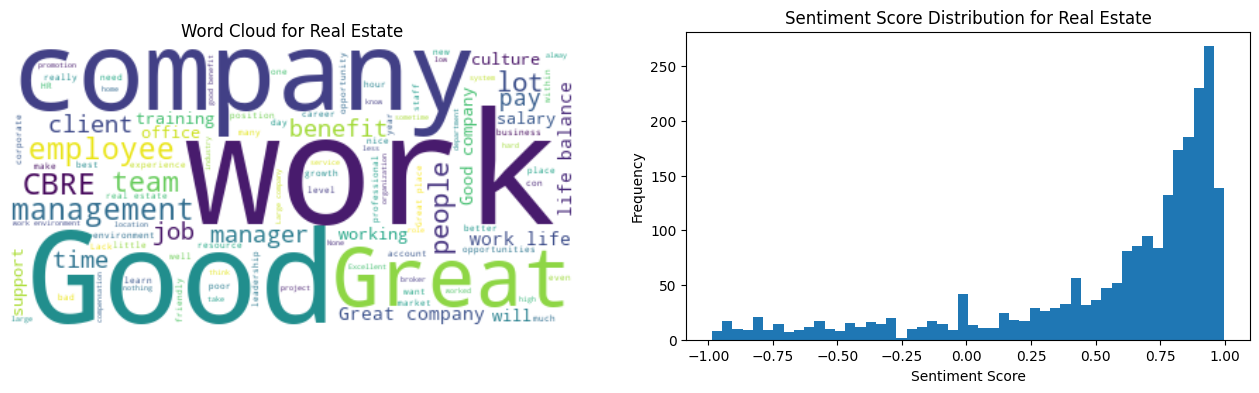

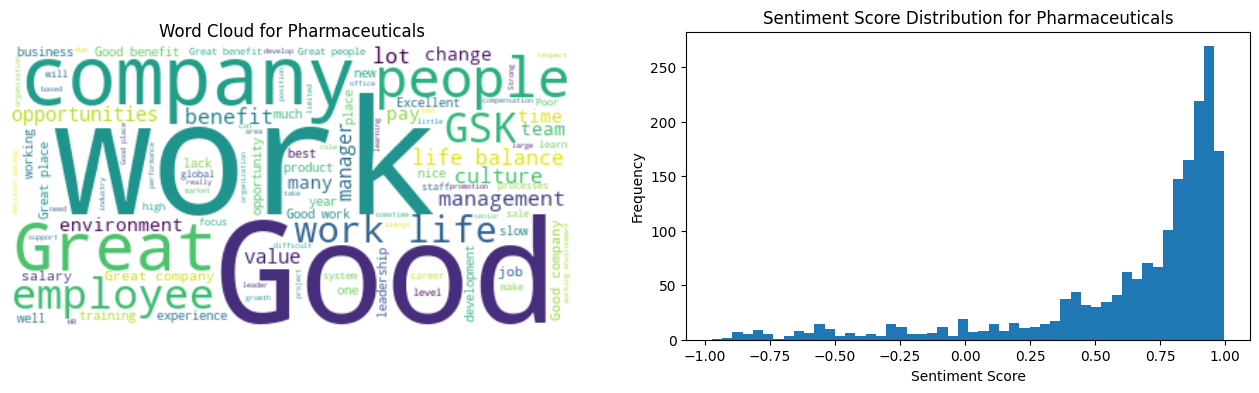

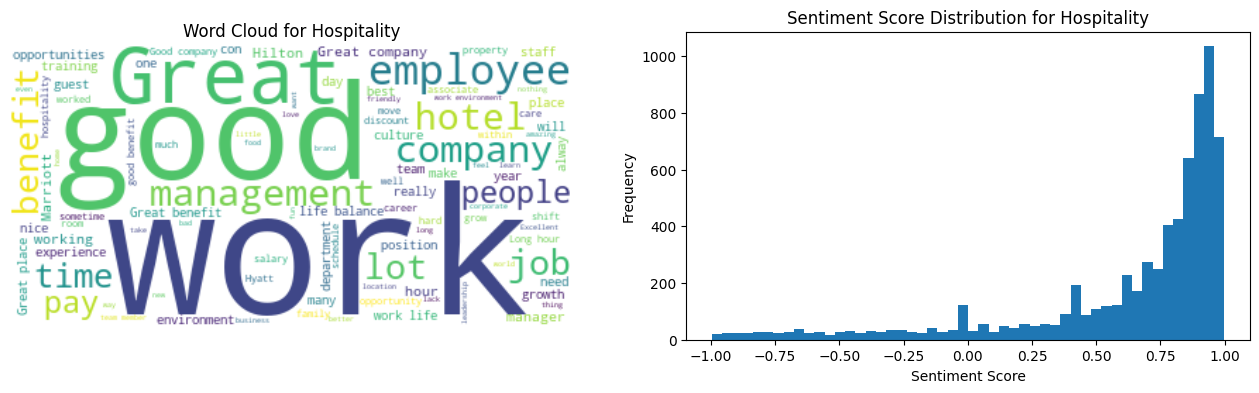

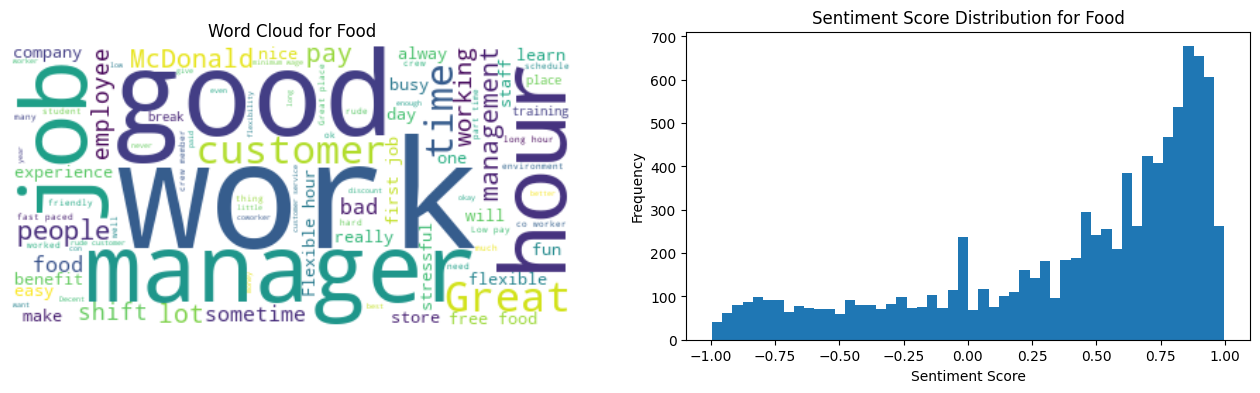

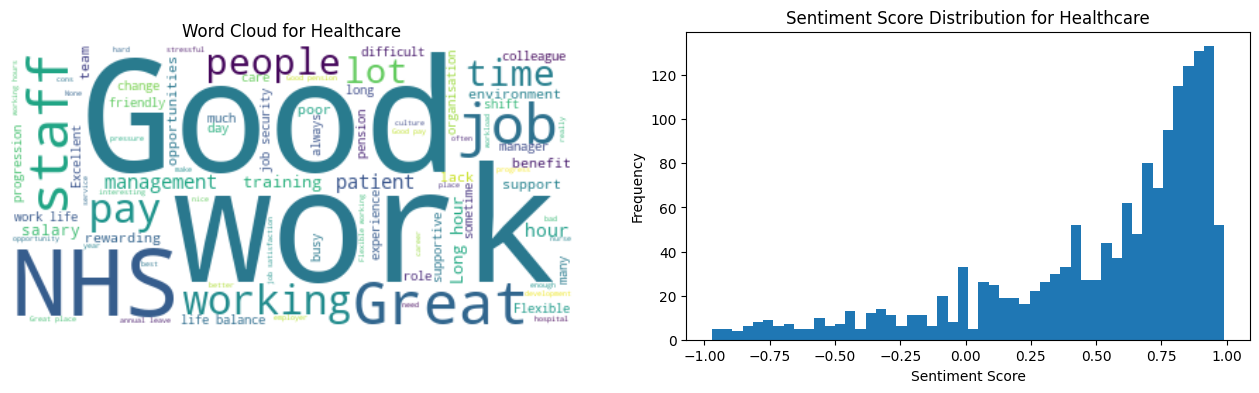

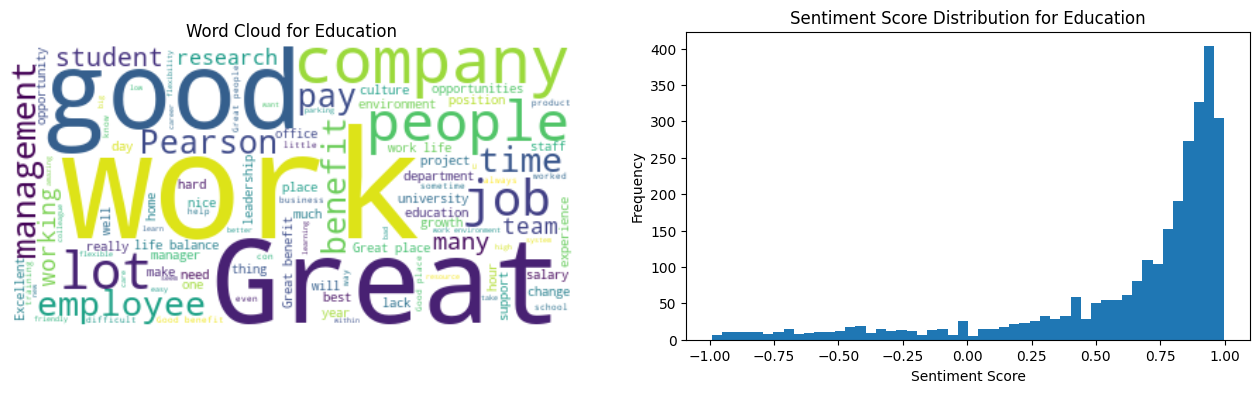

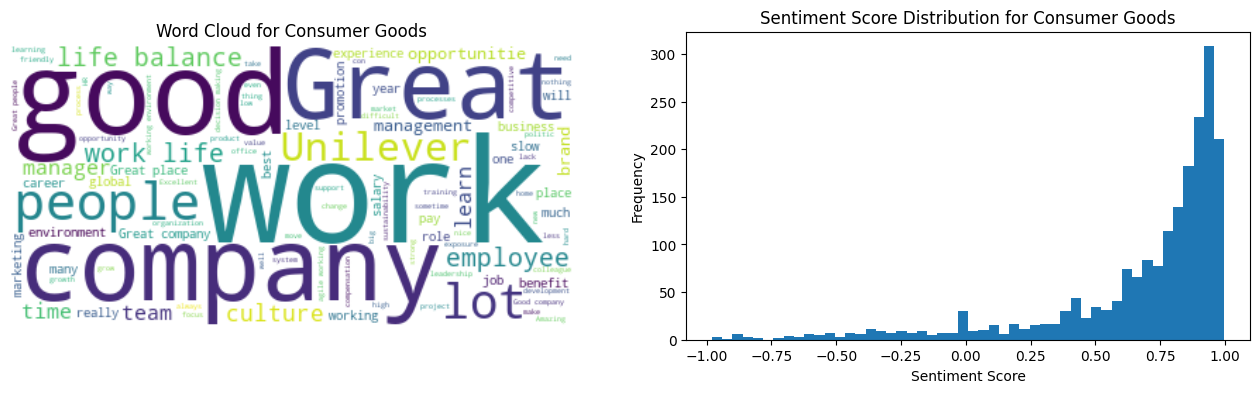

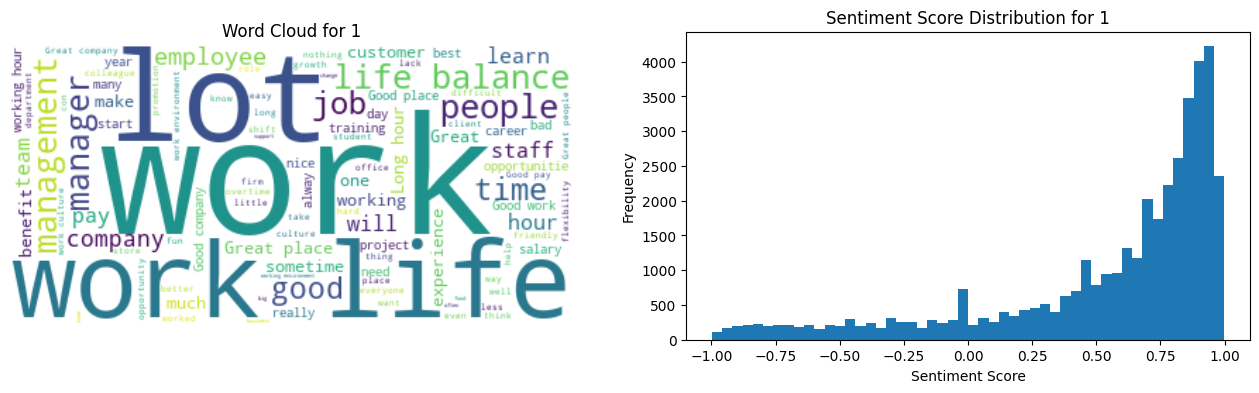

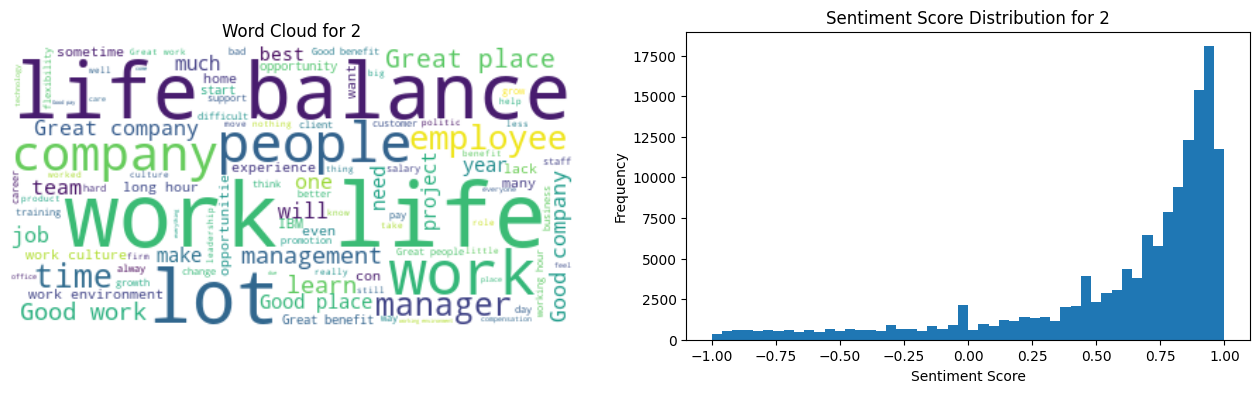

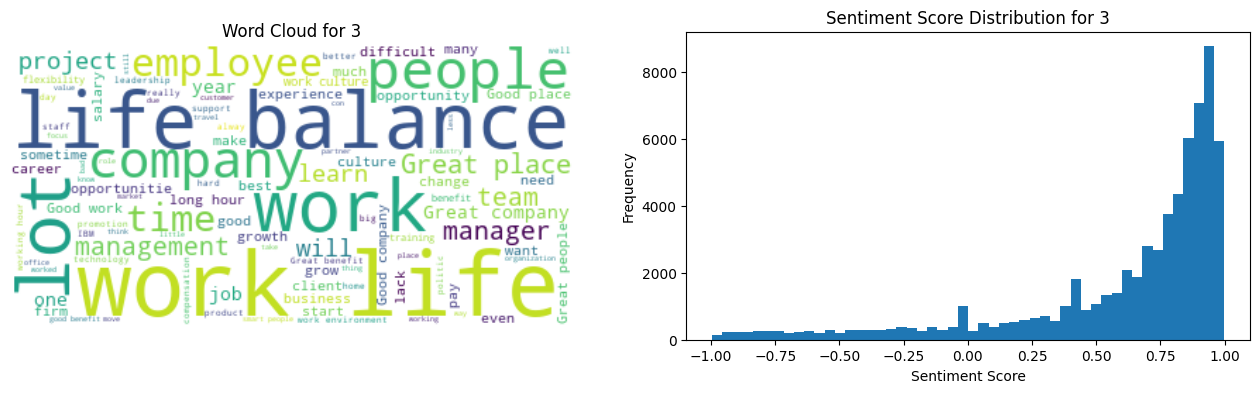

In [36]:
def keyword_analysis_by_category(df, category_col, category_value, text_col, sentiment_score_col):
    subset = df[df[category_col] == category_value]
    text = ' '.join(subset[text_col].fillna(''))

    fig, axs = plt.subplots(1, 2, figsize = (16,4))

    wordcloud = WordCloud(background_color='white', max_words=100).generate(text)
    axs[0].imshow(wordcloud, interpolation='bilinear')
    axs[0].set_title(f'Word Cloud for {category_value}')
    axs[0].axis('off')

    sentiment_scores = subset[sentiment_score_col]
    axs[1].hist(sentiment_scores, bins=50)
    axs[1].set_title(f'Sentiment Score Distribution for {category_value}')
    axs[1].set_xlabel('Sentiment Score')
    axs[1].set_ylabel('Frequency')

# by industry
industries = df['industry'].unique()
for industry in industries:
    keyword_analysis_by_category(df, 'industry', industry, 'combined_text', 'sentiment_score')

# by management level
levels = df['level'].unique()
for level in levels:
    keyword_analysis_by_category(df, 'level', level, 'combined_text', 'sentiment_score')


##### Industries
- Not too much deviation with factors within each industries

##### Management Levels:
- `work life` is prevelant in all levels of managemnt
- Level 2 and 3 seem to have a relatively balanced word cloud with relatively even factors across all variables
- Level 1 has a bold `work`, perhaps entry jobs are not content with doing most of the grunt work?

Let's compute the correlation of keywords to overall_ratings for each industry and management level

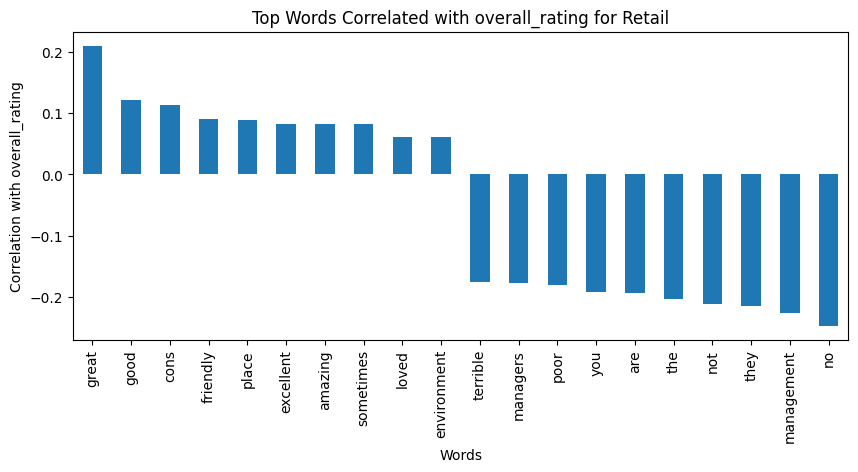

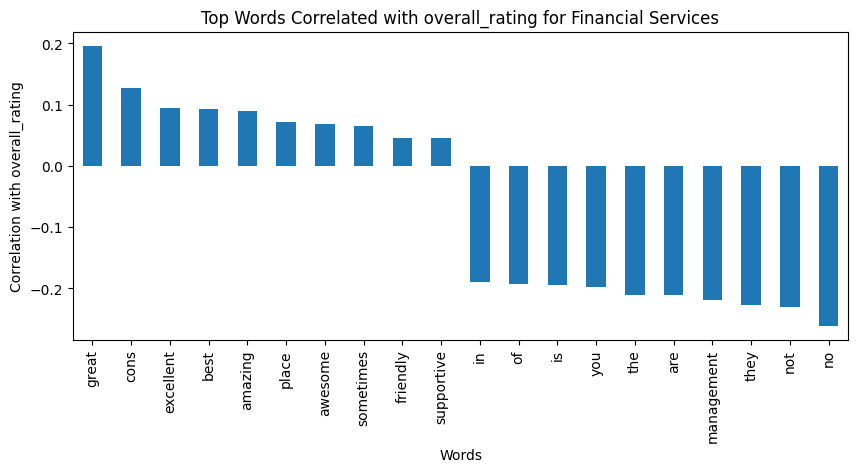

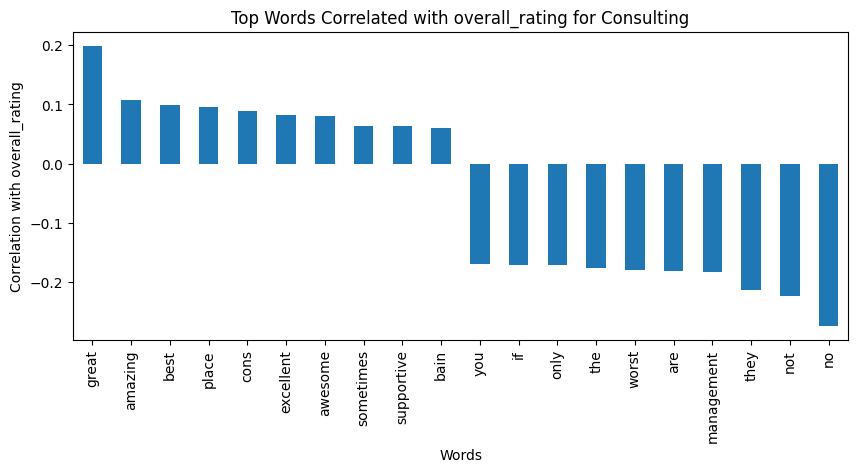

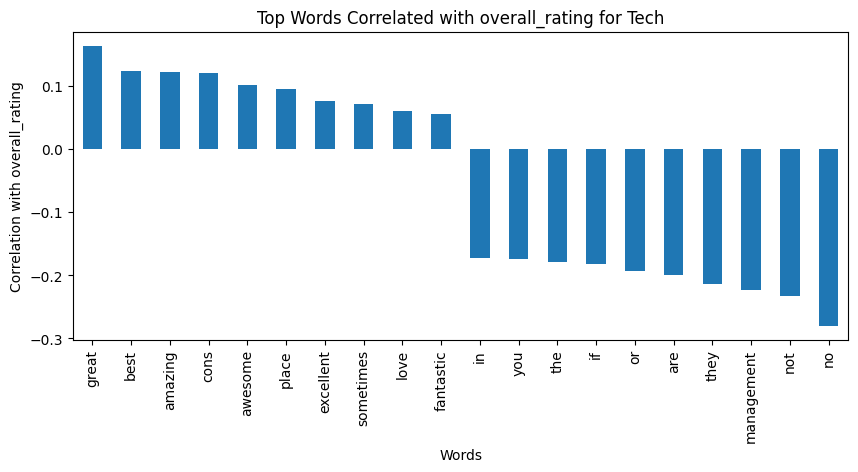

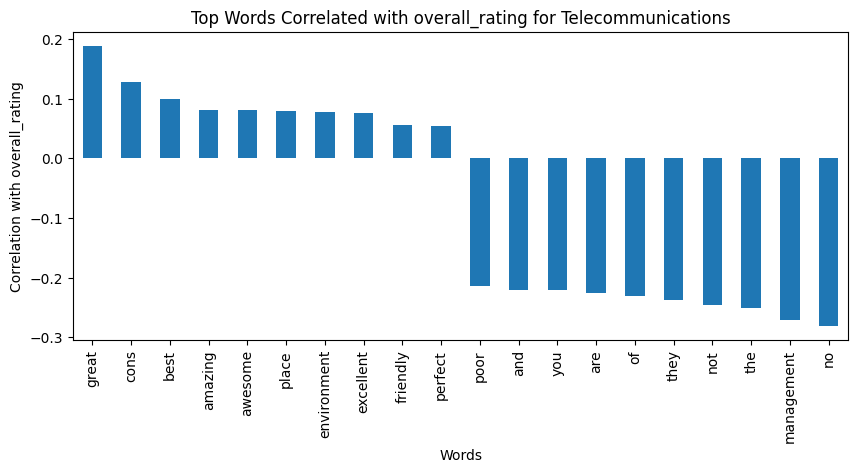

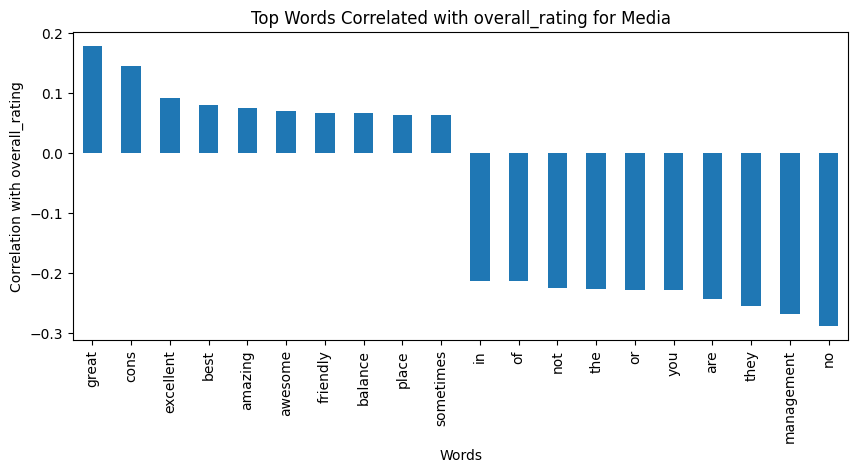

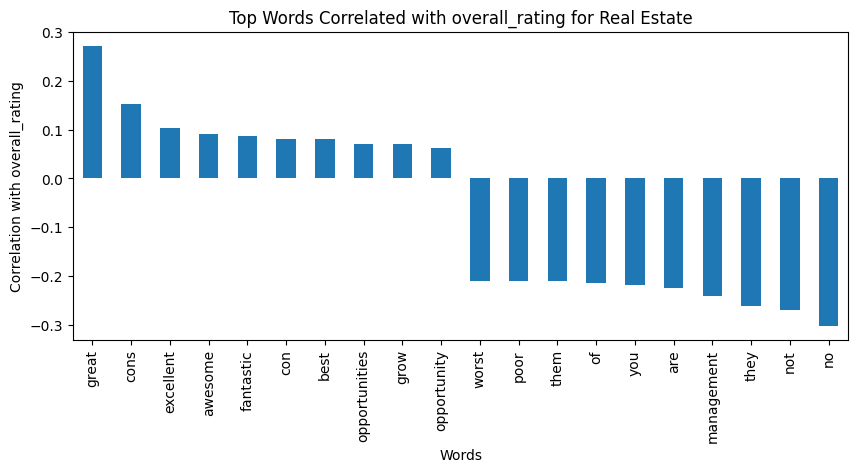

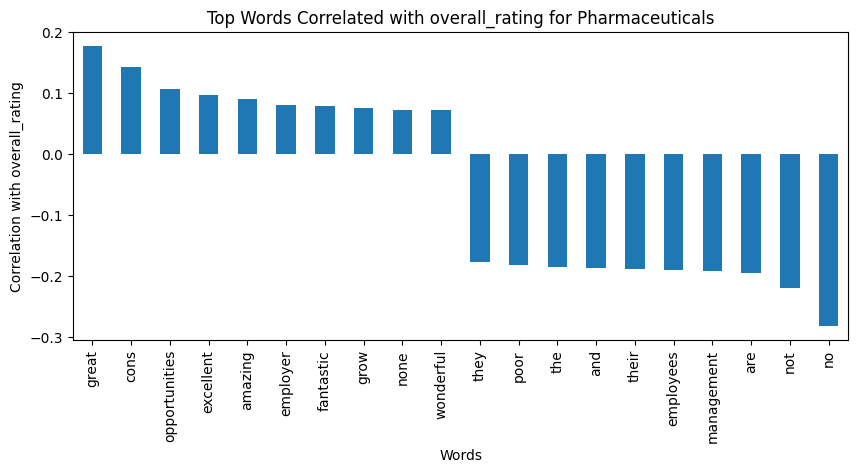

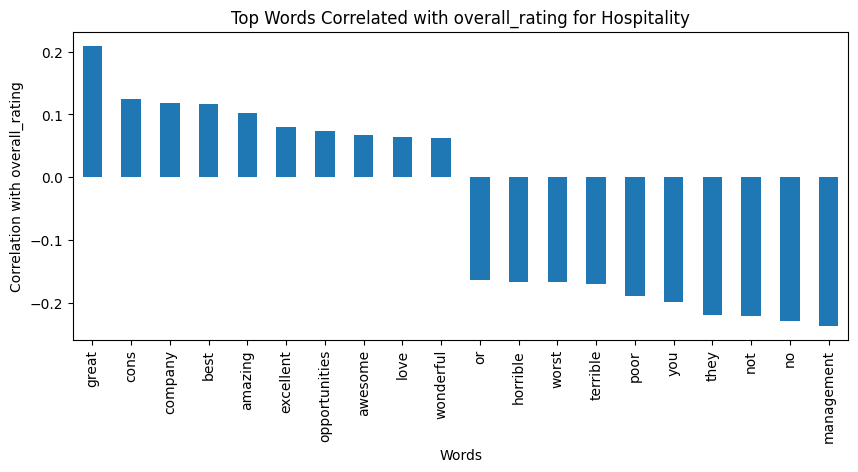

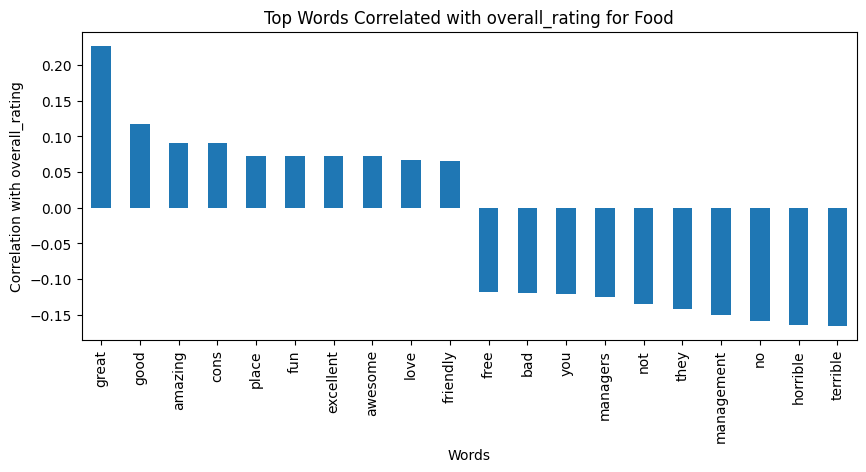

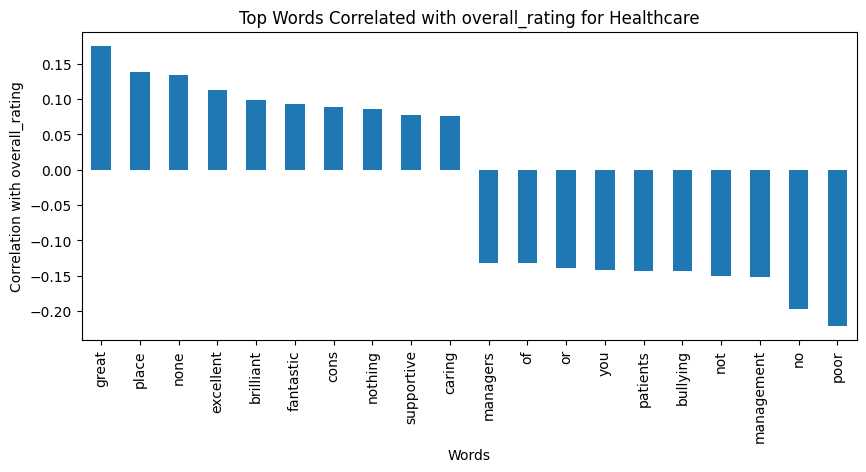

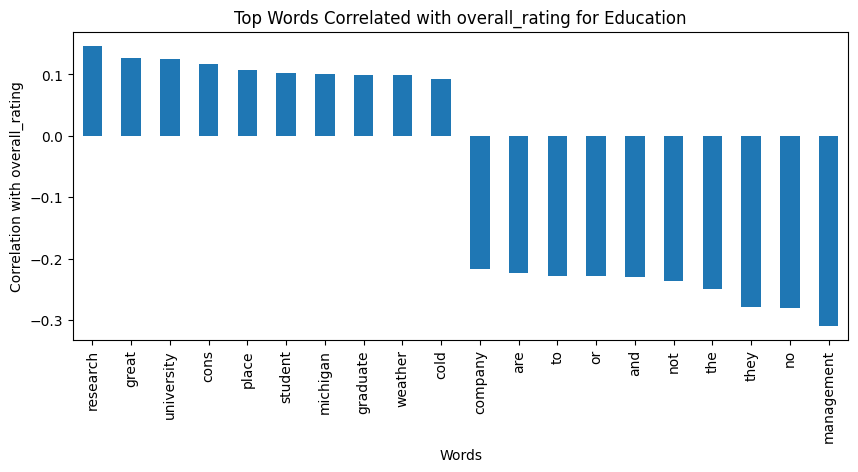

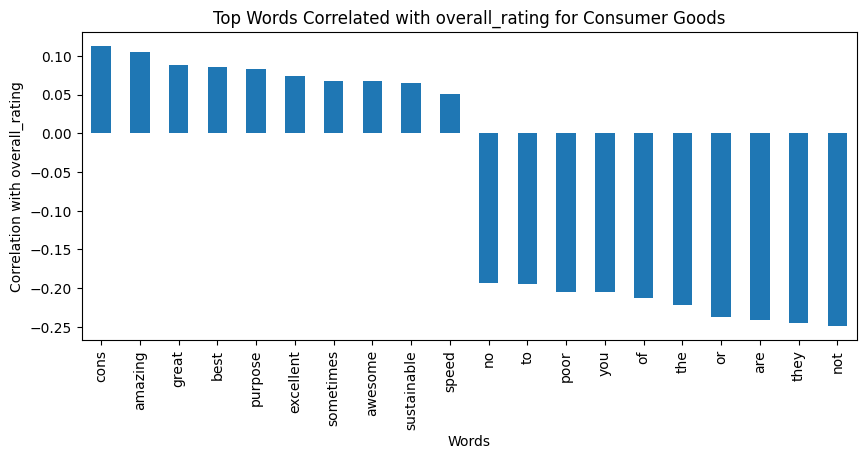

In [37]:
# compute and plot word correlations
def word_correlation_by_category(df, category_col, category_value, text_col, rating_col):
    subset = df[df[category_col] == category_value]
    
    word_vectorizer = CountVectorizer(max_features=1000)
    X_words = word_vectorizer.fit_transform(subset[text_col])
    word_features = pd.DataFrame(X_words.toarray(), columns=word_vectorizer.get_feature_names_out())
    
    # zero-variance columns -> causing divide 0 errors
    word_features = word_features.loc[:, (word_features != 0).any(axis=0)]

    correlation = word_features.apply(lambda col: np.corrcoef(col, subset[rating_col])[0, 1])
    
    correlation = correlation.dropna()
    
    top_correlated_words = correlation.sort_values(ascending=False).head(10)
    low_correlated_words = correlation.sort_values(ascending=False).tail(10)

    frames = [top_correlated_words, low_correlated_words]
    most_correlated_words = pd.concat(frames)
    most_correlated_words.plot(kind='bar', figsize=(10, 4))
    plt.title(f'Top Words Correlated with {rating_col} for {category_value}')
    plt.xlabel('Words')
    plt.ylabel(f'Correlation with {rating_col}')
    plt.show()

industries = df['industry'].unique()
for industry in industries:
    word_correlation_by_category(df, 'industry', industry, 'combined_text', 'overall_rating')

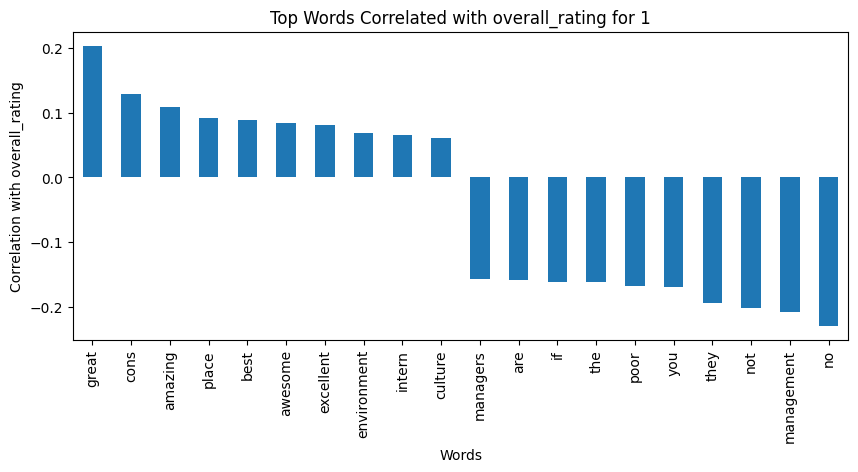

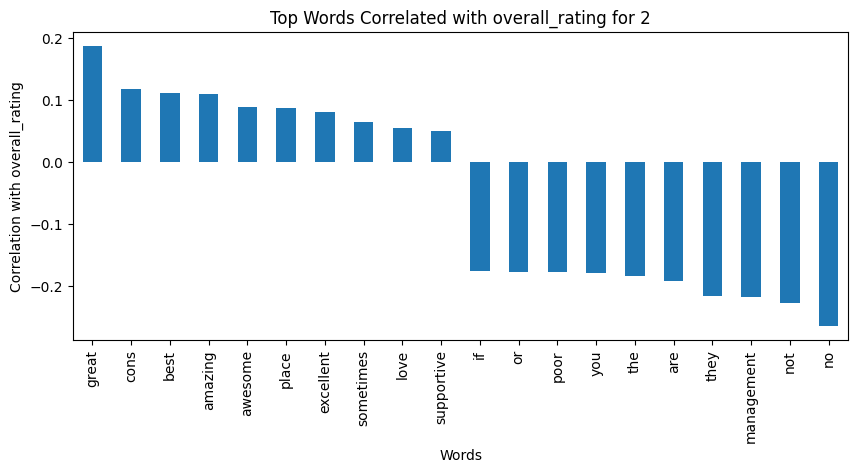

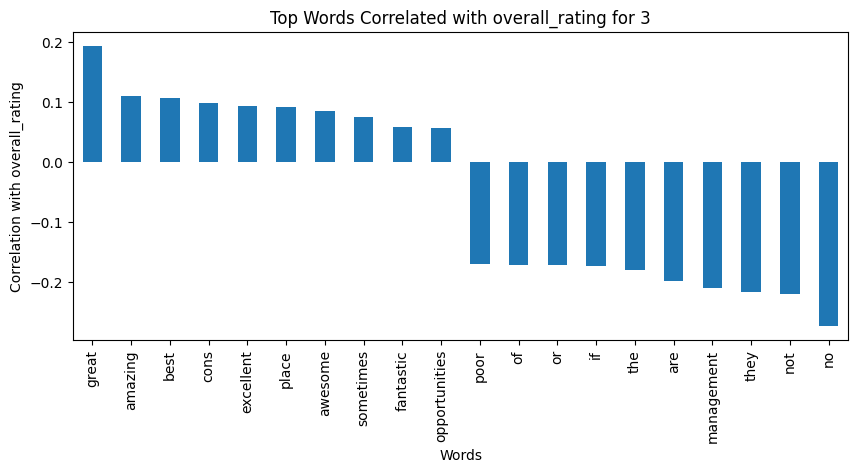

In [38]:
# Correlation analysis by management level
levels = df['level'].unique()
for level in levels:
    word_correlation_by_category(df, 'level', level, 'combined_text', 'overall_rating')

- Connotative terms "great, poor, etc" dominated the positive correlation along with the occasional `friendly`, `supportive`, `opportunities`. 
- However once again, in every category: `management`, `managers` leads to the highest negative correlation (-0.2 range)
    - Companies really have to work on employee-manager, it's killing employee attrition rates

## 3.4 Summary <a id = '3_4'></a>

- Overall Observations
    - Job Hiearchy is not correlated with rating, it seems to be all flat throughout in most industries except food/retail (lower level has much worse experience)
        - Will conduct a statisical experiment in a different NB to bettery inquiry this
        
- Variables with high impact on overall rating industry-wide:
    - Work life balance, management (managers), culture
    - Culture, Manager and Career opporunity have > .7 correlation, these have strongest positive correlation to overall_rating

- Industry/Job Level Trends
    - Different industries do have some discrepancy in what matters more in overall_ratings
    - 

- Potential Limits
    - Not enough firms that represents an industry (consumer goods, healthcare, realestate, etc)

## 3.5 Exports

In [39]:
import os

data_folder = 'CleanedData'
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

cleaned_data_path = os.path.join(data_folder, 'clean_data_2.csv')

df.to_csv(cleaned_data_path, index=False)